In [1]:
import pandas as pd # standard python data library
import geopandas as gp # the geo-version of pandas
import numpy as np 
import os
import fiona
from statistics import mean, median
from pandas import read_csv
gp.io.file.fiona.drvsupport.supported_drivers['KML'] = 'rw' #To load KML files
import string
import xml.etree.ElementTree as et
import re
from collections import Counter

pd.options.display.max_columns = 999

# Florida

## VEST Documentation

Election results from the Florida Department of State (https://dos.myflorida.com/elections/data-statistics/elections-data/precinct-level-election-results/)

Precinct results from several sources.  
- Alachua, Bay, Bradford, Brevard, Calhoun, Citrus, Clay, Dixie, Escambia, Hardee, Hendry, Hernando, Indian River, Lafayette and Sarasota come from the Department of State.  
- Broward, Gadsden, Gilchrist, Manatee, Nassau, Santa Rosa, St. Johns, St. Lucie, and Union are from the Orlando Sentinel's precinct map for the 2016 presidential primary (http://interactive.orlandosentinel.com/elections/2016/presidential-primary/results/dem.html).  
- Baker, Charlotte, Franklin, Glades, Holmes, Jackson, Jefferson, Levy, Liberty, Madison, Monroe, Okeechobee, Orange, Seminole, Suwannee, Taylor, Wakulla, Walton, and Washinton come from the U.S. Census Bureau's 2020 Redistricting Data Program.  
- Collier, Columbia, DeSoto, Duval, Flagler, Gulf, Highlands, Hillsborough, Lake, Lee, Leon, Marion, Martin, Miami-Dade, Okaloosa, Osceola, Palm Beach, Pasco, Pinellas, Polk, Putnam, Sumter, and Volusia come from the counties.
- Hamilton was drawn based on a geocoded voter registration file.  
- Edits were made to Brevard, Charlotte, Escambia, Franklin, Indian River, Jefferson, Lafayette, Lake, and Lee, Miami-Dade, and St. Johns based on the voter registration file.  

Lake 108, Osceola 999, Palm Beach 8002, Seminole 900s, and Monroe's "Cumulative" precinct (the latter appears on the county's detailed results but not the DOS's precinct results file) don't have geography. Brevard 999, Broward Z073, Collier 450, Flagler 999, Hillborough 999, Leon 9000, Miami-Dade 100, and Pinellas 512 do have geography, but they are just the county election offices. Both groups represent some type of vote not assigned to a particular geography, like UOCAVA results, so these were distributed across the county by candidate proportional to the vote each precinct recorded.

G20PRERTRU - Donald J. Trump (Republican Party)  
G20PREDBID - Joseph R. Biden (Democratic Party)  
G20PRELJOR - Jo Jorgensen (Libertarian Party)  
G20PREODEL - Roque "Rocky" De La Fuente (Reform Party)  
G20PRESLAR - Gloria La Riva (Party for Socialism and Liberation)  
G20PREGHAW - Howie Hawkin (Green Party)  
G20PRECBLA - Don Blankenship (Constitution Party)  
G20PREOWRI - Write-in Votes  

## Load VEST File

In [2]:
vest_fl_20 = gp.read_file("./raw-from-source/VEST/fl_2020/fl_2020.shp")

In [3]:
vest_fl_20.columns

Index(['pct_std', 'county', 'precinct', 'G20PRERTRU', 'G20PREDBID',
       'G20PRELJOR', 'G20PREODEL', 'G20PRESLAR', 'G20PREGHAW', 'G20PRECBLA',
       'G20PREOWRI', 'geometry'],
      dtype='object')

In [4]:
data_columns = [col for col in vest_fl_20.columns if "G20" in col]

## Load the Main Primary Election Results

Fields and codes data https://files.floridados.gov/media/694099/precinct-level-results-data-definition-field-codes.pdfF

In [5]:
#This Data is from the FL department of state, and can only be downloaded county by county
all_files = os.listdir("./raw-from-source/Election_Results/main_primary/")

#Check that all files have the same number of columns
for i in all_files:
    if i !=".DS_Store" and "recount" not in i:
        ref = "./raw-from-source/Election_Results/main_primary/"
        file_ref = ref+i
        file_prev = pd.read_csv(file_ref,sep="\t",engine='python',index_col=None, header=None)
        if (file_prev.shape[1]!=19):
            print(i)
        #print(file_prev.shape)
    
#All the files have 19 columns, so they should be good to combine

li = []
for i in all_files:
    if i !=".DS_Store" and "recount" not in i and i != "PAL_PctResults20200818.txt":
        ref = "./raw-from-source/Election_Results/main_primary/"
        file_ref = ref+i
        file_prev = pd.read_csv(file_ref,sep="\t",engine='python',index_col=None, header=None)
        li.append(file_prev)
prim_frame = pd.concat(li, axis=0, ignore_index=True)
print(prim_frame.shape)

(279939, 19)


In [6]:
sum(prim_frame[(prim_frame[0]=="SEM")][18])

718220

In [7]:
sum(prim_frame[(prim_frame[0]=="SEM") & (prim_frame[14].str.contains("Val"))][18])

13598

PCON07RVAL
- SEM: 13598 votes | 13596 votes official results 

In [8]:
frame = prim_frame.copy(deep = True)

https://files.floridados.gov/media/694099/precinct-level-results-data-definition-field-codes.pdf

In [9]:
col_rename_dict = {0: 'County Code (Three-character abbreviation)',
 1: 'County Name',
 2: 'Election Number',
 3: 'Election Date',
 4: 'Election Name',
 5: 'Unique Precinct Identifier',
 6: 'Precinct Polling Location',
 7: 'Total Registered Voters',
 8: 'Total Registered Republicans',
 9: 'Total Registered Democrats',
 10: 'Total Registered All Other Parties',
 11: 'Contest Name',
 12: 'District',
 13: 'Contest Code (Florida’s 6 digit contest codes)',
 14: 'Candidate/Retention/IssueName/WriteInsCast/OverVotes/UnderVotes',
 15: 'Candidate Party (abbreviation)',
 16: 'Candidate Florida Voter Registration System ID Number',
 17: 'DOE Assigned Candidate Number or Retention/Issue Number',
 18: 'Vote Total'}

In [10]:
frame.rename(columns = col_rename_dict, inplace = True)

In [11]:
frame["Contest Name"].unique()

array(['State Senator', 'Tax Collector', 'Superintendent of Schools',
       'County Commissioner', 'State Attorney',
       'Clerk of the Circuit Court and Comptroller', 'Sheriff',
       'Property Appraiser', 'School Board', 'Circuit Judge',
       'County Court Judge', 'Representative in Congress',
       'State Representative', 'Public Defender',
       'Port of Palm Beach District', 'Supervisor of Elections',
       'Greater Boca Raton Beach and Park District',
       'Jupiter Inlet District', 'Clerk of the Circuit Court',
       'Lake Region Lakes Management District',
       'Hendry County Hospital Authority',
       'Charlotte County Airport Authority', 'County Council Chair',
       'County Council', 'Mayor', 'Emerald Coast Utilities Authority',
       'Sarasota County Charter Review Board',
       'Sarasota County Public Hospital Board',
       'Lake County Water Authority',
       'North Lake County Hospital District',
       'Ocean Highway and Port Authority', 'City Council

In [12]:
races_list = ['Representative in Congress']

In [13]:
#Filter to the presidential results
frame =frame[frame['Contest Name'].isin(races_list)]

#Filter out the OverVotes and UnderVotes
filtered_frame = frame[~frame['Candidate/Retention/IssueName/WriteInsCast/OverVotes/UnderVotes'].isin(['OverVotes', 'UnderVotes'])]

#Clean up the precinct column
filtered_frame['Precinct Polling Location'] = filtered_frame['Precinct Polling Location'].astype(str)

#Deal with Dade County
filtered_frame["mod_col"]=filtered_frame.apply(lambda row:int(float(row['Precinct Polling Location'].split("PRECINCT ")[1])) if row['County Code (Three-character abbreviation)']=="DAD" else row['Unique Precinct Identifier'], axis=1)

#Add in exception for Sarasota - use the precinct polling location
filtered_frame["mod_col"] = np.where(filtered_frame["County Name"]=="Sarasota", filtered_frame["Precinct Polling Location"], filtered_frame["mod_col"])

#Make the precinct column at least 4 digits
filtered_frame["mod_col"]=filtered_frame["mod_col"].astype(str)
filtered_frame["modified_pre"]=filtered_frame["mod_col"].str.zfill(4)

#Make a column with the 3 letter county code and the precincts
filtered_frame["pct_std"]=filtered_frame['County Code (Three-character abbreviation)']+filtered_frame["modified_pre"]

<ipython-input-13-9307dcb97a68>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_frame['Precinct Polling Location'] = filtered_frame['Precinct Polling Location'].astype(str)
<ipython-input-13-9307dcb97a68>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_frame["mod_col"]=filtered_frame.apply(lambda row:int(float(row['Precinct Polling Location'].split("PRECINCT ")[1])) if row['County Code (Three-character abbreviation)']=="DAD" else row['Unique Precinct Identifier'], axis=1)
<ipython-input

In [14]:
filtered_frame[filtered_frame["County Name"]=="Hendry"]

,County Code (Three-character abbreviation),County Name,Election Number,Election Date,Election Name,Unique Precinct Identifier,Precinct Polling Location,Total Registered Voters,Total Registered Republicans,Total Registered Democrats,Total Registered All Other Parties,Contest Name,District,Contest Code (Florida’s 6 digit contest codes),Candidate/Retention/IssueName/WriteInsCast/OverVotes/UnderVotes,Candidate Party (abbreviation),Candidate Florida Voter Registration System ID Number,DOE Assigned Candidate Number or Retention/Issue Number,Vote Total,mod_col,modified_pre,pct_std


In [15]:
name_update_dict = {}
for i in list(filtered_frame["pct_std"]):
    if (i[0:3] == i[3:6]):
        name_update_dict[i] = i[3:]

In [16]:
filtered_frame["pct_std"]=filtered_frame["pct_std"].map(name_update_dict).fillna(filtered_frame["pct_std"])

<ipython-input-16-734311149d6e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_frame["pct_std"]=filtered_frame["pct_std"].map(name_update_dict).fillna(filtered_frame["pct_std"])


In [17]:
# Cast the contest name and code columns to string to make the pivot col
filtered_frame["Contest Name"] = filtered_frame["Contest Name"].astype(str)
filtered_frame["Contest Code (Florida’s 6 digit contest codes)"] = filtered_frame["Candidate/Retention/IssueName/WriteInsCast/OverVotes/UnderVotes"].astype(str)

<ipython-input-17-46da4f0e8365>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_frame["Contest Name"] = filtered_frame["Contest Name"].astype(str)
<ipython-input-17-46da4f0e8365>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_frame["Contest Code (Florida’s 6 digit contest codes)"] = filtered_frame["Candidate/Retention/IssueName/WriteInsCast/OverVotes/UnderVotes"].astype(str)


In [18]:
filtered_frame['Candidate Party (abbreviation)'] = filtered_frame['Candidate Party (abbreviation)'].map({' ':'WRI'}).fillna(filtered_frame['Candidate Party (abbreviation)'])

<ipython-input-18-cc08b28a7227>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_frame['Candidate Party (abbreviation)'] = filtered_frame['Candidate Party (abbreviation)'].map({' ':'WRI'}).fillna(filtered_frame['Candidate Party (abbreviation)'])


In [19]:
filtered_frame['Candidate Party (abbreviation)'].unique()

array(['REP', 'DEM'], dtype=object)

In [20]:
# Create the pivot column with the contest name and the candidate
filtered_frame["pivot_col"] = filtered_frame["Contest Name"] + "-" + filtered_frame["Contest Code (Florida’s 6 digit contest codes)"] + "-" + "PARTY:" +filtered_frame['Candidate Party (abbreviation)']  

<ipython-input-20-fe582c8917a9>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_frame["pivot_col"] = filtered_frame["Contest Name"] + "-" + filtered_frame["Contest Code (Florida’s 6 digit contest codes)"] + "-" + "PARTY:" +filtered_frame['Candidate Party (abbreviation)']


In [21]:
filtered_frame["pivot_col"].value_counts(dropna=False)

Representative in Congress-Elizabeth Felton-PARTY:REP              411
Representative in Congress-Laura Loomer-PARTY:REP                  411
Representative in Congress-Christian Acosta-PARTY:REP              411
Representative in Congress-Lois Frankel-PARTY:DEM                  411
Representative in Congress-Aaron Scanlan-PARTY:REP                 411
                                                                  ... 
Representative in Congress-Daniel Kowal-PARTY:REP                  147
Representative in Congress-David Holden-PARTY:DEM                  147
Representative in Congress-William "Fig" Figlesthaler-PARTY:REP    147
Representative in Congress-Willie J. Montague-PARTY:REP            144
Representative in Congress-Vennia Francois-PARTY:REP               144
Name: pivot_col, Length: 91, dtype: int64

In [22]:
# Where it exists, add in the district to the pivot column
filtered_frame.loc[:,"pivot_col"] = np.where((filtered_frame["pivot_col"].str.contains("President")), filtered_frame["pivot_col"], filtered_frame["pivot_col"] + "-" + filtered_frame["District"])

/Users/peterhorton/opt/anaconda3/envs/geo_env/lib/python3.9/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [23]:
filtered_frame["pivot_col"].value_counts(dropna=False)

Representative in Congress-Laura Loomer-PARTY:REP-District 21                  411
Representative in Congress-Aaron Scanlan-PARTY:REP-District 21                 411
Representative in Congress-Michael Vilardi-PARTY:REP-District 21               411
Representative in Congress-Reba Sherrill-PARTY:REP-District 21                 411
Representative in Congress-Elizabeth Felton-PARTY:REP-District 21              411
                                                                              ... 
Representative in Congress-Darren Aquino-PARTY:REP-District 19                 147
Representative in Congress-William "Fig" Figlesthaler-PARTY:REP-District 19    147
Representative in Congress-Casey Askar-PARTY:REP-District 19                   147
Representative in Congress-Vennia Francois-PARTY:REP-District 10               144
Representative in Congress-Willie J. Montague-PARTY:REP-District 10            144
Name: pivot_col, Length: 91, dtype: int64

In [24]:
filtered_frame[filtered_frame["County Name"] == "Leon"]

,County Code (Three-character abbreviation),County Name,Election Number,Election Date,Election Name,Unique Precinct Identifier,Precinct Polling Location,Total Registered Voters,Total Registered Republicans,Total Registered Democrats,Total Registered All Other Parties,Contest Name,District,Contest Code (Florida’s 6 digit contest codes),Candidate/Retention/IssueName/WriteInsCast/OverVotes/UnderVotes,Candidate Party (abbreviation),Candidate Florida Voter Registration System ID Number,DOE Assigned Candidate Number or Retention/Issue Number,Vote Total,mod_col,modified_pre,pct_std,pivot_col
265056,LEO,Leon,10865,08/18/2020,2020 Primary Election,1203,1203-5205 -- John Wesley United Methodist Church,2793,418,0,0,Representative in Congress,District 5,Gary Adler,Gary Adler,REP,103559929,75184,56,1203,1203,LEO1203,Representative in Congress-Gary Adler-PARTY:RE...
265057,LEO,Leon,10865,08/18/2020,2020 Primary Election,1205,5203-1205-1230 -- Optimist Park,1160,180,0,0,Representative in Congress,District 5,Gary Adler,Gary Adler,REP,103559929,75184,29,1205,1205,LEO1205,Representative in Congress-Gary Adler-PARTY:RE...
265058,LEO,Leon,10865,08/18/2020,2020 Primary Election,1230,5203-1205-1230 -- Optimist Park,643,151,0,0,Representative in Congress,District 5,Gary Adler,Gary Adler,REP,103559929,75184,18,1230,1230,LEO1230,Representative in Congress-Gary Adler-PARTY:RE...
265059,LEO,Leon,10865,08/18/2020,2020 Primary Election,1251,1321-1251 -- Jack L. Mclean Center,82,6,0,0,Representative in Congress,District 5,Gary Adler,Gary Adler,REP,103559929,75184,0,1251,1251,LEO1251,Representative in Congress-Gary Adler-PARTY:RE...
265060,LEO,Leon,10865,08/18/2020,2020 Primary Election,1255,1255-1258 -- Faith Christian Family Center,954,172,0,0,Representative in Congress,District 5,Gary Adler,Gary Adler,REP,103559929,75184,26,1255,1255,LEO1255,Representative in Congress-Gary Adler-PARTY:RE...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
265681,LEO,Leon,10865,08/18/2020,2020 Primary Election,5258,5224-5223-5258 -- Gospel Light Church,2,0,2,0,Representative in Congress,District 5,Al Lawson,Al Lawson,DEM,104987227,75494,0,5258,5258,LEO5258,Representative in Congress-Al Lawson-PARTY:DEM...
265682,LEO,Leon,10865,08/18/2020,2020 Primary Election,5260,5260 -- Woodrun Baptist Church,3885,0,2297,0,Representative in Congress,District 5,Al Lawson,Al Lawson,DEM,104987227,75494,896,5260,5260,LEO5260,Representative in Congress-Al Lawson-PARTY:DEM...
265683,LEO,Leon,10865,08/18/2020,2020 Primary Election,5264,5263-5264-5265 -- Dorothy Spence Community Center,116,0,90,0,Representative in Congress,District 5,Al Lawson,Al Lawson,DEM,104987227,75494,31,5264,5264,LEO5264,Representative in Congress-Al Lawson-PARTY:DEM...
265684,LEO,Leon,10865,08/18/2020,2020 Primary Election,5265,5263-5264-5265 -- Dorothy Spence Community Center,91,0,72,0,Representative in Congress,District 5,Al Lawson,Al Lawson,DEM,104987227,75494,34,5265,5265,LEO5265,Representative in Congress-Al Lawson-PARTY:DEM...


### Pivot the Data

In [25]:
# Removing all of the specific party registration data, as it looks like the state doesn't have that
for val in ['Total Registered Republicans','Total Registered Democrats', 'Total Registered All Other Parties']:
    print(filtered_frame[val].unique())

[ 534   50 1113 ... 1640 1209  817]
[   0  334  760 ... 1015  192  130]
[0]


In [26]:
filtered_frame.drop(['Election Number', 'Election Date', 'Total Registered Republicans','Total Registered Democrats', 'Total Registered All Other Parties','Candidate Florida Voter Registration System ID Number','DOE Assigned Candidate Number or Retention/Issue Number'], axis = 1, inplace = True)

/Users/peterhorton/opt/anaconda3/envs/geo_env/lib/python3.9/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [27]:
#Pivot the data so that each row has all the results from that precinct
pivoted_2020 = pd.pivot_table(filtered_frame, values=['Vote Total'], index=["pct_std",'County Code (Three-character abbreviation)','County Name'],columns=['pivot_col'],aggfunc=sum)

#pivoted_2020 = pd.pivot_table(filtered_frame, values=['Vote Total'], index=["pct_std"],columns=['County Code (Three-character abbreviation)','County Name','Total Registered Voters','pivot_col'],aggfunc=sum)


#Clean up the indices
pivoted_2020.reset_index(inplace=True,drop=False)

In [28]:
pivoted_2020.columns

MultiIndex([(                                   'pct_std', ...),
            ('County Code (Three-character abbreviation)', ...),
            (                               'County Name', ...),
            (                                'Vote Total', ...),
            (                                'Vote Total', ...),
            (                                'Vote Total', ...),
            (                                'Vote Total', ...),
            (                                'Vote Total', ...),
            (                                'Vote Total', ...),
            (                                'Vote Total', ...),
            (                                'Vote Total', ...),
            (                                'Vote Total', ...),
            (                                'Vote Total', ...),
            (                                'Vote Total', ...),
            (                                'Vote Total', ...),
            (            

In [29]:
pivoted_2020.columns = [' '.join(col).strip() for col in pivoted_2020.columns.values]

In [30]:
pivoted_2020.columns = pivoted_2020.columns.str.replace("Vote Total ","")

In [31]:
pivoted_2020 = pivoted_2020.fillna(0)

In [32]:
pivoted_2020[pivoted_2020["pct_std"]=="LEO9000"]

,pct_std,County Code (Three-character abbreviation),County Name,Representative in Congress-Aaron Scanlan-PARTY:REP-District 21,Representative in Congress-Adam Christensen-PARTY:DEM-District 3,Representative in Congress-Adam Hattersley-PARTY:DEM-District 15,Representative in Congress-Al Lawson-PARTY:DEM-District 5,Representative in Congress-Alan Cohn-PARTY:DEM-District 15,Representative in Congress-Albert Chester-PARTY:DEM-District 5,Representative in Congress-Alcee L. Hastings-PARTY:DEM-District 20,Representative in Congress-Amanda Makki-PARTY:REP-District 13,Representative in Congress-Amy Pope Wells-PARTY:REP-District 3,Representative in Congress-Anna Paulina Luna-PARTY:REP-District 13,Representative in Congress-Bill Engelbrecht-PARTY:REP-District 3,Representative in Congress-Bill Posey-PARTY:REP-District 8,Representative in Congress-Brian Mast-PARTY:REP-District 18,Representative in Congress-Byron Donalds-PARTY:REP-District 19,Representative in Congress-Carla Spalding-PARTY:REP-District 23,Representative in Congress-Carlos Gimenez-PARTY:REP-District 26,Representative in Congress-Casey Askar-PARTY:REP-District 19,Representative in Congress-Christian Acosta-PARTY:REP-District 21,Representative in Congress-Christine Y. Quinn-PARTY:REP-District 14,Representative in Congress-Christopher Wright-PARTY:REP-District 9,Representative in Congress-Christy McLaughlin-PARTY:REP-District 19,Representative in Congress-Cindy Lyn Banyai-PARTY:DEM-District 19,Representative in Congress-Clint Curtis-PARTY:DEM-District 6,Representative in Congress-Dan Severson-PARTY:REP-District 19,Representative in Congress-Dane Eagle-PARTY:REP-District 19,Representative in Congress-Daniel Kowal-PARTY:REP-District 19,Representative in Congress-Darlene Swaffar-PARTY:REP-District 22,Representative in Congress-Darren Aquino-PARTY:REP-District 19,Representative in Congress-David Holden-PARTY:DEM-District 19,Representative in Congress-David Theus-PARTY:REP-District 3,Representative in Congress-Debbie Wasserman Schultz-PARTY:DEM-District 23,Representative in Congress-Elizabeth Felton-PARTY:REP-District 21,Representative in Congress-Erick J. Aguilar-PARTY:REP-District 4,Representative in Congress-Fran Flynn-PARTY:REP-District 22,Representative in Congress-Frederica Wilson-PARTY:DEM-District 24,Representative in Congress-Gary Adler-PARTY:REP-District 5,Representative in Congress-Gavin Rollins-PARTY:REP-District 3,Representative in Congress-George Buck-PARTY:REP-District 13,Representative in Congress-Greg Merk-PARTY:REP-District 1,Representative in Congress-Greg Musselwhite-PARTY:REP-District 20,Representative in Congress-Guido Weiss-PARTY:DEM-District 21,"Representative in Congress-James ""Jim"" Pruden-PARTY:REP-District 22",Representative in Congress-James St. George-PARTY:REP-District 3,"Representative in Congress-Jennifer ""Jen"" Perelman-PARTY:DEM-District 23",Representative in Congress-Jesse Philippe-PARTY:DEM-District 15,"Representative in Congress-Jessica ""Jessi"" Melton-PARTY:REP-District 22",Representative in Congress-Joe Dallas Millado-PARTY:REP-District 3,Representative in Congress-John H. Rutherford-PARTY:REP-District 4,Representative in Congress-John Mills-PARTY:REP-District 1,Representative in Congress-Jose Castillo-PARTY:REP-District 9,Representative in Congress-Juan Fiol-PARTY:REP-District 27,Representative in Congress-Judson Sapp-PARTY:REP-District 3,Representative in Congress-Kat Cammack-PARTY:REP-District 3,"Representative in Congress-LaShonda ""L.J."" Holloway-PARTY:DEM-District 5",Representative in Congress-Laura Loomer-PARTY:REP-District 21,Representative in Congress-Leo Valentfn-PARTY:REP-District 7,Representative in Congress-Lois Frankel-PARTY:DEM-District 21,Representative in Congress-Maria Elvira Salazar-PARTY:REP-District 27,Representative in Congress-Matt Gaetz-PARTY:REP-District 1,Representative in Congress-Michael Kroske-PARTY:REP-District 23,Representative in Congress-Michael Vilardi-PARTY:REP-District 21,Representative in Congress-Nick 

## Look into split precincts

In [33]:
def is_split_precinct(district_assignment_list):
    c = Counter([x[0] for x in district_assignment_list])
    greater_than_one = {x:[y[1] for y in district_assignment_list if y[0]==x] for x, count in c.items() if count > 1}
    if len(greater_than_one)==0:
        return 0
    else:
        return greater_than_one

In [34]:
district_cols = [i for i in pivoted_2020.columns if "Representative" in i or "State Senator" in i]

In [35]:
def get_level_dist(column_name):
    zfill_level = 2
    if "Representative in Congress" in column_name:
        level = "CON"
    elif "State Senator" in column_name:
        level = "SU"
    elif "State Representative" in column_name:
        level = "SL"
        zfill_level = 3
    else:
        raise ValueError
    return_val = re.findall("District \S*",column_name) 
    if (len(return_val)!=0):
        dist = return_val[0].split(" ")[1]
        dist = dist.zfill(zfill_level)
    else:
        raise ValueError
    return level,dist

In [36]:
precinct_mapping_dict = {}
split_precincts_list = {}
for index,row in pivoted_2020.iterrows():
    # print(row)
    precinct_list = []
    for contest in district_cols:
        if(row[contest]!=0):
            # print(contest)
            precinct_info = get_level_dist(contest)
            # print(precinct_info)
            if precinct_info not in precinct_list:
                precinct_list.append(get_level_dist(contest))
    is_split = is_split_precinct(precinct_list)
    if (is_split):
        split_precincts_list[row["pct_std"]]=is_split
    precinct_mapping_dict[row["pct_std"]]=precinct_list

## Rename Columns

In [37]:
keep_names = ['pct_std', 'County Code (Three-character abbreviation)', 'County Name']

In [38]:
def get_race(contest):
    if "President" in contest:
        level = "PRE"
    elif ("Representative in Congress" in contest or "State Senator" in contest or "State Representative" in contest):
        contest_info = get_level_dist(contest)
        level = contest_info[0]+contest_info[1]        
    else:
        print(contest)
        raise ValueError
    return level

In [39]:
def get_party(contest):
    if "PARTY:DEM" in contest:
        return "D"
    elif "PARTY:REP" in contest:
        return "R"
    else:
        print(contest)
        return ValueError

In [40]:
def get_name(contest):
    contest = contest.upper()
    name = contest.split("-")[1]
    likely_last = name.split(" ")[-1]
    if likely_last in ["JR","III","II","SR"]:
        return name.split(" ")[-2][0:3]
    else:
        return likely_last[0:3]

In [41]:
races_list = ['Representative in Congress','State Representative','State Senator']

In [42]:
list(pivoted_2020.columns)

['pct_std',
 'County Code (Three-character abbreviation)',
 'County Name',
 'Representative in Congress-Aaron Scanlan-PARTY:REP-District 21',
 'Representative in Congress-Adam Christensen-PARTY:DEM-District 3',
 'Representative in Congress-Adam Hattersley-PARTY:DEM-District 15',
 'Representative in Congress-Al Lawson-PARTY:DEM-District 5',
 'Representative in Congress-Alan Cohn-PARTY:DEM-District 15',
 'Representative in Congress-Albert Chester-PARTY:DEM-District 5',
 'Representative in Congress-Alcee L. Hastings-PARTY:DEM-District 20',
 'Representative in Congress-Amanda Makki-PARTY:REP-District 13',
 'Representative in Congress-Amy Pope Wells-PARTY:REP-District 3',
 'Representative in Congress-Anna Paulina Luna-PARTY:REP-District 13',
 'Representative in Congress-Bill Engelbrecht-PARTY:REP-District 3',
 'Representative in Congress-Bill Posey-PARTY:REP-District 8',
 'Representative in Congress-Brian Mast-PARTY:REP-District 18',
 'Representative in Congress-Byron Donalds-PARTY:REP-Dist

In [43]:
contest_name_change_dict = {}

In [44]:
duplicate_value_list = []
for contest in pivoted_2020.columns:
    if contest not in keep_names:
        # Add in a condition about the 20
        if "President" in contest:
            value = "P20"+ get_race(contest)+ get_party(contest)+ get_name(contest)
            if value in contest_name_change_dict.values():
                duplicate_value_list.append(value)
            contest_name_change_dict[contest] = value 
        else:
            value = "P"+ get_race(contest)+ get_party(contest)+ get_name(contest)
            if value in contest_name_change_dict.values():
                duplicate_value_list.append(value)
            contest_name_change_dict[contest] = value
#     else:
#         print("'"+contest+"':'',")
if len(duplicate_value_list) > 0:
    print("DUPLICATE VALUES")
    for val in [(k,v) for k, v in contest_name_change_dict.items() if v in duplicate_value_list]:
        print(val)

DUPLICATE VALUES
('Representative in Congress-Ryan D. Chamberlin-PARTY:REP-District 3', 'PCON03RCHA')
('Representative in Congress-Todd Chase-PARTY:REP-District 3', 'PCON03RCHA')


In [45]:
contest_name_change_dict['Representative in Congress-Ryan D. Chamberlin-PARTY:REP-District 3'] = 'PCON03RCHM'
contest_name_change_dict['Representative in Congress-Todd Chase-PARTY:REP-District 3'] = 'PCON03RCHS'

In [46]:
pivoted_2020.rename(columns=contest_name_change_dict,inplace=True)

In [47]:
contest_name_change_dict

{'Representative in Congress-Aaron Scanlan-PARTY:REP-District 21': 'PCON21RSCA',
 'Representative in Congress-Adam Christensen-PARTY:DEM-District 3': 'PCON03DCHR',
 'Representative in Congress-Adam Hattersley-PARTY:DEM-District 15': 'PCON15DHAT',
 'Representative in Congress-Al Lawson-PARTY:DEM-District 5': 'PCON05DLAW',
 'Representative in Congress-Alan Cohn-PARTY:DEM-District 15': 'PCON15DCOH',
 'Representative in Congress-Albert Chester-PARTY:DEM-District 5': 'PCON05DCHE',
 'Representative in Congress-Alcee L. Hastings-PARTY:DEM-District 20': 'PCON20DHAS',
 'Representative in Congress-Amanda Makki-PARTY:REP-District 13': 'PCON13RMAK',
 'Representative in Congress-Amy Pope Wells-PARTY:REP-District 3': 'PCON03RWEL',
 'Representative in Congress-Anna Paulina Luna-PARTY:REP-District 13': 'PCON13RLUN',
 'Representative in Congress-Bill Engelbrecht-PARTY:REP-District 3': 'PCON03RENG',
 'Representative in Congress-Bill Posey-PARTY:REP-District 8': 'PCON08RPOS',
 'Representative in Congress

In [48]:
df = pd.DataFrame([(v, k.split("-")[1]) for k, v in contest_name_change_dict.items()], columns=['Candidate', 'Column'])
# Store the data into a csv file
df.sort_values('Candidate', inplace = True)
#df.to_csv('./non_sw_cand_dict.csv', sep=',')

In [49]:
equal_counties = []
diff_counties_dict = {}
for val in list(pivoted_2020["County Code (Three-character abbreviation)"].unique()):
    elections = pivoted_2020[pivoted_2020["County Code (Three-character abbreviation)"]==val].shape[0]
    vest = vest_fl_20[vest_fl_20["county"]==val].shape[0]
    if (elections != vest):
        diff_counties_dict[val] = [vest,elections]
    else:
        equal_counties.append(val)

In [50]:
diff_counties_dict

{'BRE': [173, 171],
 'CLL': [61, 35],
 'CLM': [22, 9],
 'DAD': [783, 658],
 'HIL': [390, 316],
 'HOL': [8, 6],
 'LAK': [103, 46],
 'LEE': [127, 112],
 'LEO': [164, 90],
 'MRN': [122, 51],
 'PAL': [871, 872],
 'PIN': [301, 241],
 'POL': [167, 142],
 'SEM': [80, 90]}

In [51]:
for val in diff_counties_dict.keys():
    print(val)
    join = pd.merge(vest_fl_20[vest_fl_20["county"]==val], pivoted_2020[pivoted_2020["County Code (Three-character abbreviation)"]==val], how = "outer", on = "pct_std", indicator = True)
    
    print(join["_merge"].value_counts())
    print(join[join["_merge"] == "left_only"]["pct_std"])
    
    

BRE
both          171
left_only       2
right_only      0
Name: _merge, dtype: int64
0     BRE0000
31    BRE0134
Name: pct_std, dtype: object
CLL
both          35
left_only     26
right_only     0
Name: _merge, dtype: int64
1     CLL0102
7     CLL0144
20    CLL0242
26    CLL0303
27    CLL0304
28    CLL0310
29    CLL0313
30    CLL0315
31    CLL0317
32    CLL0322
33    CLL0323
34    CLL0324
35    CLL0332
40    CLL0431
42    CLL0438
43    CLL0440
51    CLL0502
52    CLL0550
53    CLL0551
54    CLL0552
55    CLL0554
56    CLL0590
57    CLL0591
58    CLL0593
59    CLL0594
60    CLL0416
Name: pct_std, dtype: object
CLM
left_only     13
both           9
right_only     0
Name: _merge, dtype: int64
2     CLM0013
7     CLM0021
8     CLM0022
9     CLM0023
10    CLM0031
11    CLM0032
12    CLM0033
15    CLM0042
16    CLM0043
17    CLM0044
19    CLM0052
20    CLM0053
21    CLM0054
Name: pct_std, dtype: object
DAD
both          658
left_only     125
right_only      0
Name: _merge, dtype: int64
203  

## Filter Columns

In [52]:
list(pivoted_2020.columns)

['pct_std',
 'County Code (Three-character abbreviation)',
 'County Name',
 'PCON21RSCA',
 'PCON03DCHR',
 'PCON15DHAT',
 'PCON05DLAW',
 'PCON15DCOH',
 'PCON05DCHE',
 'PCON20DHAS',
 'PCON13RMAK',
 'PCON03RWEL',
 'PCON13RLUN',
 'PCON03RENG',
 'PCON08RPOS',
 'PCON18RMAS',
 'PCON19RDON',
 'PCON23RSPA',
 'PCON26RGIM',
 'PCON19RASK',
 'PCON21RACO',
 'PCON14RQUI',
 'PCON09RWRI',
 'PCON19RMCL',
 'PCON19DBAN',
 'PCON06DCUR',
 'PCON19RSEV',
 'PCON19REAG',
 'PCON19RKOW',
 'PCON22RSWA',
 'PCON19RAQU',
 'PCON19DHOL',
 'PCON03RTHE',
 'PCON23DSCH',
 'PCON21RFEL',
 'PCON04RAGU',
 'PCON22RFLY',
 'PCON24DWIL',
 'PCON05RADL',
 'PCON03RROL',
 'PCON13RBUC',
 'PCON01RMER',
 'PCON20RMUS',
 'PCON21DWEI',
 'PCON22RPRU',
 'PCON03RGEO',
 'PCON23DPER',
 'PCON15DPHI',
 'PCON22RMEL',
 'PCON03RMIL',
 'PCON04RRUT',
 'PCON01RMIL',
 'PCON09RCAS',
 'PCON27RFIO',
 'PCON03RSAP',
 'PCON03RCAM',
 'PCON05DHOL',
 'PCON21RLOO',
 'PCON07RVAL',
 'PCON21DFRA',
 'PCON27RSAL',
 'PCON01RGAE',
 'PCON23RKRO',
 'PCON21RVIL',
 'PCON18RV

In [53]:
keep_columns = ['pct_std', 'County Code (Three-character abbreviation)', 'County Name']

state_data_columns = [i for i in pivoted_2020.columns if i not in keep_columns]

pivoted_2020_sldl = pivoted_2020[keep_columns+[i for i in pivoted_2020.columns if ("PSL" in i)]]
pivoted_2020_sldu = pivoted_2020[keep_columns+[i for i in pivoted_2020.columns if ("PSU" in i)]]
pivoted_2020_cong = pivoted_2020[keep_columns+[i for i in pivoted_2020.columns if ("PCON" in i)]]

### Precinct-by-Precinct Check

In [54]:
#Check if the columns are unique
print(vest_fl_20["pct_std"].value_counts(dropna=False))
print(pivoted_2020["pct_std"].value_counts(dropna=False))

ORA0222    1
GAD0024    1
HIL0550    1
DAD0835    1
VOL0718    1
          ..
DAD0310    1
HIL0145    1
ORA0435    1
HIL0412    1
DAD0354    1
Name: pct_std, Length: 6011, dtype: int64
ORA0222    1
DAD0099    1
PAL6224    1
PAL7004    1
DAD0521    1
          ..
ESC0097    1
DUV1111    1
ORA0513    1
BROR055    1
VOL0309    1
Name: pct_std, Length: 4766, dtype: int64


In [55]:
ser = pivoted_2020["pct_std"].value_counts(dropna=False)

In [56]:
dup_ids = ser[ser > 1].index

In [57]:
data_columns_full = [i for i in pivoted_2020.columns if i not in ['pct_std', 'County Code (Three-character abbreviation)', 'County Name','REG_VOTERS',"county"]]

In [58]:
# #Combine results in these two precincts to match VEST
# pivoted_2020_st =pivoted_2020_st.fillna(0)
# for i in state_data_columns:
#     print(i)
#     pivoted_2020_st[i] = pivoted_2020_st[i].astype(int)
    
#     pivoted_2020_st.loc[pivoted_2020_st["pct_std"]=="CHA54.0",i]+=int(pivoted_2020_st.loc[pivoted_2020_st["pct_std"]=="CHA54.1",i])

# #Check that it works
# pivoted_2020_st.loc[pivoted_2020_st["pct_std"]=="CHA54.0"]

# #Remove the precinct that the votes were added from
# pivoted_2020_st = pivoted_2020_st[pivoted_2020_st["pct_std"]!="CHA54.1"]

### Allocate votes

From VEST's documentation:

> Lake 108, Osceola 999, Palm Beach 8002, Seminole 900s, and Monroe's "Cumulative" precinct (the latter appears on the county's detailed results but not the DOS's precinct results file) don't have geography. Brevard 999, Broward Z073, Collier 450, Flagler 999, Hillborough 999, Leon 9000, Miami-Dade 100, and Pinellas 512 do have geography, but they are just the county election offices. Both groups represent some type of vote not assigned to a particular geography, like UOCAVA results, so these were distributed across the county by candidate proportional to the vote each precinct recorded.

In [59]:
election_vest_id_changes = pd.read_csv("./st_id_changes_dict_non_sw.csv")
election_vest_id_changes_dict = dict(zip(election_vest_id_changes["primary_ID"],election_vest_id_changes["vest_ID"]))


    

In [60]:
pivoted_2020["pct_std"] = pivoted_2020["pct_std"].map(election_vest_id_changes_dict).fillna(pivoted_2020["pct_std"])

In [61]:
join_attempt_one = pd.merge(vest_fl_20,pivoted_2020,how="outer",on="pct_std",indicator=True)
print(join_attempt_one["_merge"].value_counts())



both          4754
left_only     1257
right_only      12
Name: _merge, dtype: int64


In [62]:
join_attempt_one[join_attempt_one["_merge"]=="right_only"]

,pct_std,county,precinct,G20PRERTRU,G20PREDBID,G20PRELJOR,G20PREODEL,G20PRESLAR,G20PREGHAW,G20PRECBLA,G20PREOWRI,geometry,County Code (Three-character abbreviation),County Name,PCON21RSCA,PCON03DCHR,PCON15DHAT,PCON05DLAW,PCON15DCOH,PCON05DCHE,PCON20DHAS,PCON13RMAK,PCON03RWEL,PCON13RLUN,PCON03RENG,PCON08RPOS,PCON18RMAS,PCON19RDON,PCON23RSPA,PCON26RGIM,PCON19RASK,PCON21RACO,PCON14RQUI,PCON09RWRI,PCON19RMCL,PCON19DBAN,PCON06DCUR,PCON19RSEV,PCON19REAG,PCON19RKOW,PCON22RSWA,PCON19RAQU,PCON19DHOL,PCON03RTHE,PCON23DSCH,PCON21RFEL,PCON04RAGU,PCON22RFLY,PCON24DWIL,PCON05RADL,PCON03RROL,PCON13RBUC,PCON01RMER,PCON20RMUS,PCON21DWEI,PCON22RPRU,PCON03RGEO,PCON23DPER,PCON15DPHI,PCON22RMEL,PCON03RMIL,PCON04RRUT,PCON01RMIL,PCON09RCAS,PCON27RFIO,PCON03RSAP,PCON03RCAM,PCON05DHOL,PCON21RLOO,PCON07RVAL,PCON21DFRA,PCON27RSAL,PCON01RGAE,PCON23RKRO,PCON21RVIL,PCON18RVES,PCON26RBLA,PCON18DVAZ,PCON18DKEI,PCON14RELL,PCON03DDOD,PCON19RHEN,PCON27RMOL,PCON21RSHE,PCON24DFUE,PCON07RGOB,PCON06DTHR,PCON05RWAG,PCON15RSPA,PCON03RCHM,PCON24DLEH,PCON08RCAI,PCON15RFRA,PCON09RORT,PCON13RNEW,PCON20DCHE,PCON13RGRI,PCON03RCHS,PCON03DWEL,PCON10RFRA,PCON20RDEG,PCON19RFIG,PCON09ROLS,PCON10RMON,PCON07RZHA,_merge
6011,PAL8001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,PAL,Palm Beach,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,right_only
6012,PAL8002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,PAL,Palm Beach,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,right_only
6013,SEM0081,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,SEM,Seminole,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,right_only
6014,SEM0082,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,SEM,Seminole,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,right_only
6015,SEM0083,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,SEM,Seminole,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,right_only
6016,SEM0084,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,SEM,Seminole,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,right_only
6017,SEM0085,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,SEM,Seminole,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

# Completed: Counties to look into:
- PAL
    - The votes from these precincts just need to be allocated
- HEN
    - The confusing thing about Hendado is "10 - PRE01" vs "1 - PRE10"
    - Primary file:
        - What is called "10 - PRE01" in primary has votes for County Commissioner District 1
        - What is called "1 - PRE10" in primary has votes for County Commissioner District 4
    - General file:
        - No county commissioner district 1 results in the general
        - What is called "10 - PRE010" in general has votes for County Commissioner District 4
    - Go by the precinct # for these

## Look into unjoined VEST votes, make sure they make sense

In [63]:
counties_w_unjoined = list(join_attempt_one[join_attempt_one["_merge"]=="left_only"]["county"].unique())

join_attempt_one[join_attempt_one["_merge"]=="left_only"]["county"].value_counts()

DAD    125
PAS    112
SAR    101
HIL     74
LEO     74
MRN     71
MAN     70
CHA     67
PIN     60
LAK     57
BAY     44
HER     32
CIT     31
SUM     26
CLL     26
POL     25
HIG     25
SUW     16
DES     15
LEE     15
JAC     14
TAY     14
LEV     13
GLA     13
CLM     13
WAS     12
WAK     12
HAR     12
CAL     11
OKE     11
GIL     10
HEN     10
GUL     10
DIX     10
FRA      8
LIB      8
LAF      5
HOL      2
BRE      2
PAL      1
Name: county, dtype: int64

In [64]:
for county in counties_w_unjoined:
    print(county)
    print(vest_fl_20[vest_fl_20["county"]==county].shape)
    print(join_attempt_one[(join_attempt_one["_merge"]=="left_only") & (join_attempt_one["county"]==county)].shape)

BAY
(44, 12)
(44, 106)
CAL
(11, 12)
(11, 106)
CHA
(67, 12)
(67, 106)
CIT
(31, 12)
(31, 106)
CLM
(22, 12)
(13, 106)
DES
(15, 12)
(15, 106)
DIX
(10, 12)
(10, 106)
FRA
(8, 12)
(8, 106)
GIL
(10, 12)
(10, 106)
GLA
(13, 12)
(13, 106)
HAR
(12, 12)
(12, 106)
HEN
(10, 12)
(10, 106)
HER
(32, 12)
(32, 106)
HIG
(25, 12)
(25, 106)
HIL
(390, 12)
(74, 106)
HOL
(8, 12)
(2, 106)
JAC
(14, 12)
(14, 106)
LAF
(5, 12)
(5, 106)
LEE
(127, 12)
(15, 106)
LEV
(13, 12)
(13, 106)
LIB
(8, 12)
(8, 106)
MAN
(70, 12)
(70, 106)
OKE
(11, 12)
(11, 106)
PIN
(301, 12)
(60, 106)
POL
(167, 12)
(25, 106)
SAR
(101, 12)
(101, 106)
SUM
(26, 12)
(26, 106)
SUW
(16, 12)
(16, 106)
TAY
(14, 12)
(14, 106)
WAK
(12, 12)
(12, 106)
WAS
(12, 12)
(12, 106)
BRE
(173, 12)
(2, 106)
CLL
(61, 12)
(26, 106)
GUL
(10, 12)
(10, 106)
LAK
(103, 12)
(57, 106)
LEO
(164, 12)
(74, 106)
MRN
(122, 12)
(71, 106)
DAD
(783, 12)
(125, 106)
PAL
(871, 12)
(1, 106)
PAS
(112, 12)
(112, 106)


## Allocate Votes

In [65]:
for val in list(join_attempt_one[join_attempt_one["_merge"]=="right_only"]["pct_std"]):
    print(val)

PAL8001
PAL8002
SEM0081
SEM0082
SEM0083
SEM0084
SEM0085
SEM0086
SEM0087
SEM0088
SEM0089
SEM0090


In [66]:
sem_diff = pd.DataFrame(0, index=np.arange(1), columns = pivoted_2020.columns)
sem_diff["pct_std"] = "SEMDIFF"
sem_diff["County Code (Three-character abbreviation)"] = "SEM"
sem_diff["County Name"] = "Seminole"

In [67]:
sem_diff['PCON07RVAL'] = -2

In [68]:
pivoted_2020 = pd.concat([pivoted_2020, sem_diff], ignore_index = True, axis = 0)

In [69]:
# extra_to_allocate = pd.read_csv("./raw-from-source/Election_Results/pivot_to_build_allocation.csv")
# pivoted_2020_st = pd.concat([pivoted_2020_st, extra_to_allocate])
to_allocate = ['FLA0999',
 'LAK0108',
 'OSC0999',
 'PAL8001',
 'PAL8002',
'SEM0081',
'SEM0082',
'SEM0083',
'SEM0084',
'SEM0085',
'SEM0086',
'SEM0087',
'SEM0088',
'SEM0089',
'SEM0090',
'BRE0999','DAD0100','BROZ073','CHA0054','CLL0450','HIL0999',"LEO9000",'PIN0512', "SEMDIFF"]

In [70]:
pivoted_2020[pivoted_2020["pct_std"]=="LEO9000"]

,pct_std,County Code (Three-character abbreviation),County Name,PCON21RSCA,PCON03DCHR,PCON15DHAT,PCON05DLAW,PCON15DCOH,PCON05DCHE,PCON20DHAS,PCON13RMAK,PCON03RWEL,PCON13RLUN,PCON03RENG,PCON08RPOS,PCON18RMAS,PCON19RDON,PCON23RSPA,PCON26RGIM,PCON19RASK,PCON21RACO,PCON14RQUI,PCON09RWRI,PCON19RMCL,PCON19DBAN,PCON06DCUR,PCON19RSEV,PCON19REAG,PCON19RKOW,PCON22RSWA,PCON19RAQU,PCON19DHOL,PCON03RTHE,PCON23DSCH,PCON21RFEL,PCON04RAGU,PCON22RFLY,PCON24DWIL,PCON05RADL,PCON03RROL,PCON13RBUC,PCON01RMER,PCON20RMUS,PCON21DWEI,PCON22RPRU,PCON03RGEO,PCON23DPER,PCON15DPHI,PCON22RMEL,PCON03RMIL,PCON04RRUT,PCON01RMIL,PCON09RCAS,PCON27RFIO,PCON03RSAP,PCON03RCAM,PCON05DHOL,PCON21RLOO,PCON07RVAL,PCON21DFRA,PCON27RSAL,PCON01RGAE,PCON23RKRO,PCON21RVIL,PCON18RVES,PCON26RBLA,PCON18DVAZ,PCON18DKEI,PCON14RELL,PCON03DDOD,PCON19RHEN,PCON27RMOL,PCON21RSHE,PCON24DFUE,PCON07RGOB,PCON06DTHR,PCON05RWAG,PCON15RSPA,PCON03RCHM,PCON24DLEH,PCON08RCAI,PCON15RFRA,PCON09RORT,PCON13RNEW,PCON20DCHE,PCON13RGRI,PCON03RCHS,PCON03DWEL,PCON10RFRA,PCON20RDEG,PCON19RFIG,PCON09ROLS,PCON10RMON,PCON07RZHA
2541,LEO9000,LEO,Leon,0.0,0.0,0.0,31.0,0.0,13.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [71]:
to_allocate

['FLA0999',
 'LAK0108',
 'OSC0999',
 'PAL8001',
 'PAL8002',
 'SEM0081',
 'SEM0082',
 'SEM0083',
 'SEM0084',
 'SEM0085',
 'SEM0086',
 'SEM0087',
 'SEM0088',
 'SEM0089',
 'SEM0090',
 'BRE0999',
 'DAD0100',
 'BROZ073',
 'CHA0054',
 'CLL0450',
 'HIL0999',
 'LEO9000',
 'PIN0512',
 'SEMDIFF']

In [72]:
allocating_votes = pivoted_2020[pivoted_2020["pct_std"].isin(to_allocate)]
receiving_votes = pivoted_2020[~pivoted_2020["pct_std"].isin(to_allocate)]

In [73]:
allocating_votes

,pct_std,County Code (Three-character abbreviation),County Name,PCON21RSCA,PCON03DCHR,PCON15DHAT,PCON05DLAW,PCON15DCOH,PCON05DCHE,PCON20DHAS,PCON13RMAK,PCON03RWEL,PCON13RLUN,PCON03RENG,PCON08RPOS,PCON18RMAS,PCON19RDON,PCON23RSPA,PCON26RGIM,PCON19RASK,PCON21RACO,PCON14RQUI,PCON09RWRI,PCON19RMCL,PCON19DBAN,PCON06DCUR,PCON19RSEV,PCON19REAG,PCON19RKOW,PCON22RSWA,PCON19RAQU,PCON19DHOL,PCON03RTHE,PCON23DSCH,PCON21RFEL,PCON04RAGU,PCON22RFLY,PCON24DWIL,PCON05RADL,PCON03RROL,PCON13RBUC,PCON01RMER,PCON20RMUS,PCON21DWEI,PCON22RPRU,PCON03RGEO,PCON23DPER,PCON15DPHI,PCON22RMEL,PCON03RMIL,PCON04RRUT,PCON01RMIL,PCON09RCAS,PCON27RFIO,PCON03RSAP,PCON03RCAM,PCON05DHOL,PCON21RLOO,PCON07RVAL,PCON21DFRA,PCON27RSAL,PCON01RGAE,PCON23RKRO,PCON21RVIL,PCON18RVES,PCON26RBLA,PCON18DVAZ,PCON18DKEI,PCON14RELL,PCON03DDOD,PCON19RHEN,PCON27RMOL,PCON21RSHE,PCON24DFUE,PCON07RGOB,PCON06DTHR,PCON05RWAG,PCON15RSPA,PCON03RCHM,PCON24DLEH,PCON08RCAI,PCON15RFRA,PCON09RORT,PCON13RNEW,PCON20DCHE,PCON13RGRI,PCON03RCHS,PCON03DWEL,PCON10RFRA,PCON20RDEG,PCON19RFIG,PCON09ROLS,PCON10RMON,PCON07RZHA
256,BRE0999,BRE,Brevard,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
833,BROZ073,BRO,Broward,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
909,CLL0450,CLL,Collier,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,2.0,0.0,0.0,0.0,5.0,9.0,0.0,2.0,3.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
970,DAD0100,DAD,Miami-Dade,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,24.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,1.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2236,HIL0999,HIL,Hillsborough,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,61.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2541,LEO9000,LEO,Leon,0.0,0.0,0.0,31.0,0.0,13.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3949,PAL8001,PAL,Palm Beach,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3950,PAL8002,PAL,Palm Beach,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0

In [74]:
receiving_votes.head()

,pct_std,County Code (Three-character abbreviation),County Name,PCON21RSCA,PCON03DCHR,PCON15DHAT,PCON05DLAW,PCON15DCOH,PCON05DCHE,PCON20DHAS,PCON13RMAK,PCON03RWEL,PCON13RLUN,PCON03RENG,PCON08RPOS,PCON18RMAS,PCON19RDON,PCON23RSPA,PCON26RGIM,PCON19RASK,PCON21RACO,PCON14RQUI,PCON09RWRI,PCON19RMCL,PCON19DBAN,PCON06DCUR,PCON19RSEV,PCON19REAG,PCON19RKOW,PCON22RSWA,PCON19RAQU,PCON19DHOL,PCON03RTHE,PCON23DSCH,PCON21RFEL,PCON04RAGU,PCON22RFLY,PCON24DWIL,PCON05RADL,PCON03RROL,PCON13RBUC,PCON01RMER,PCON20RMUS,PCON21DWEI,PCON22RPRU,PCON03RGEO,PCON23DPER,PCON15DPHI,PCON22RMEL,PCON03RMIL,PCON04RRUT,PCON01RMIL,PCON09RCAS,PCON27RFIO,PCON03RSAP,PCON03RCAM,PCON05DHOL,PCON21RLOO,PCON07RVAL,PCON21DFRA,PCON27RSAL,PCON01RGAE,PCON23RKRO,PCON21RVIL,PCON18RVES,PCON26RBLA,PCON18DVAZ,PCON18DKEI,PCON14RELL,PCON03DDOD,PCON19RHEN,PCON27RMOL,PCON21RSHE,PCON24DFUE,PCON07RGOB,PCON06DTHR,PCON05RWAG,PCON15RSPA,PCON03RCHM,PCON24DLEH,PCON08RCAI,PCON15RFRA,PCON09RORT,PCON13RNEW,PCON20DCHE,PCON13RGRI,PCON03RCHS,PCON03DWEL,PCON10RFRA,PCON20RDEG,PCON19RFIG,PCON09ROLS,PCON10RMON,PCON07RZHA
0,ALA0001,ALA,Alachua,0.0,75.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,23.0,0.0,0.0,0.0,0.0,0.0,44.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,49.0,82.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,65.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ALA0002,ALA,Alachua,0.0,134.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,66.0,0.0,0.0,0.0,0.0,0.0,43.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,51.0,98.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,129.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,42.0,157.0,0.0,0.0,0.0,0.0,0.0,0.0
2,ALA0003,ALA,Alachua,0.0,212.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,136.0,0.0,0.0,0.0,0.0,0.0,57.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,102.0,213.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,249.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,115.0,215.0,0.0,0.0,0.0,0.0,0.0,0.0
3,ALA0004,ALA,Alachua,0.0,160.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,123.0,0.0,0.0,0.0,0.0,0.0,29.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,84.0,299.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,152.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,63.0,141.0,0.0,0.0,0.0,0.0,0.0,0.0
4,ALA0005,ALA,Alachua,0.0,230.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,17.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,23.0,25.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,238.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36.0,175.0,0.0,0.0,0.0,0.0,0.0,0.0


In [75]:
def allocate_absentee(df_receiving_votes,df_allocating,column_list,col_allocating,allocating_to_all_empty_precs=False):
    """Allocates votes proportionally to precincts, usually by share of precinct-reported vote

    Args:
      df_receiving_votes: DataFrame with precinct-level votes
      df_allocating: DataFrame with the votes to allocate
      column_list: List of races that votes are being allocated for
      col_allocating: String referring to what level the allocation occurs at (most often county)
      allocating_to_all_empty_precs: Boolean for special case where all votes in df_receiving_votes are 0

    Returns:
      The precinct-level votes dataframe (df_receiving_votes) with the allocated votes
    """
    
    #Fill any n/a values with 0
    df_receiving_votes = df_receiving_votes.fillna(0)
    #Grab the original columns, so we can filter back down to them later
    original_cols = list(df_receiving_votes.columns)
    
    #Add in the "Total Votes column"
    if (allocating_to_all_empty_precs):
        #In cases where every vote is 0, need to set the Total_Votes equal to 1 for proportional allocation
        df_receiving_votes.loc[:,"Total_Votes"]=1
    else:
        df_receiving_votes.loc[:,"Total_Votes"]=0
        for race in column_list:
            df_receiving_votes.loc[:,"Total_Votes"]+=df_receiving_votes.loc[:,race]
    
    #Create the needed dataframes
    precinct_specific_totals = pd.DataFrame(df_receiving_votes.groupby([col_allocating]).sum())
    precinct_specific_totals.reset_index(drop=False,inplace=True)
    to_dole_out_totals = pd.DataFrame(df_allocating.groupby([col_allocating]).sum())
    to_dole_out_totals.reset_index(drop=False,inplace=True)
    
    #Add in total sum check
    sum_dataframe = pd.DataFrame(columns=precinct_specific_totals.columns)
    for i in column_list:
        total_votes = precinct_specific_totals.loc[:,i].sum()+to_dole_out_totals.loc[:,i].sum()
        sum_dataframe.at[0,i]=total_votes.astype(int)
    
    #Check the allocating to empty precincts code
    if (allocating_to_all_empty_precs):
        for i in column_list:
            if(sum(precinct_specific_totals[i])!=0):
                print("Allocating to all empty precincts parameter incorrect")
                break
    
    #Print out any instances where the allocation, as written, won't work
    special_allocation_needed = []
    for index, row in precinct_specific_totals.iterrows():
        for race in column_list:
            if (row[race]==0):
                race_district = row[col_allocating]
                if race_district in to_dole_out_totals[col_allocating].unique():
                    to_allocate = int(to_dole_out_totals.loc[to_dole_out_totals[col_allocating]==race_district][race])
                    if (to_allocate != 0):
                        special_allocation_needed.append([race_district,race])
                        if(row["Total_Votes"]==0):
                            precinct_specific_totals.loc[index,"Total_Votes"]=1
                            col_val = row[col_allocating]
                            df_receiving_votes.loc[df_receiving_votes[col_allocating]==col_val,"Total_Votes"]=1

    #Create some new columns for each of these races to deal with the allocation
    for race in column_list:
        add_var = race+"_add"
        rem_var = race+"_rem"
        floor_var = race+"_floor"
        df_receiving_votes.loc[:,add_var]=0.0
        df_receiving_votes.loc[:,rem_var]=0.0
        df_receiving_votes.loc[:,floor_var]=0.0

    #Iterate over the rows
    #Note this function iterates over the dataframe two times so the rounded vote totals match the totals to allocate
    for index, row in df_receiving_votes.iterrows():
        if row[col_allocating] in to_dole_out_totals[col_allocating].unique():
            for race in column_list:
                add_var = race+"_add"
                rem_var = race+"_rem"
                floor_var = race+"_floor"
                #Grab the district
                county_id = row[col_allocating]
                if [county_id,race] in special_allocation_needed:
                    #Get the denominator for the allocation - the summed "total votes" for precincts in that grouping
                    denom = precinct_specific_totals.loc[precinct_specific_totals[col_allocating]==county_id]["Total_Votes"]
                    #Get one of the numerators, how many districtwide votes to allocate
                    numer = to_dole_out_totals.loc[to_dole_out_totals[col_allocating]==county_id][race]
                    #Get the "total votes" for this particular precinct
                    val = df_receiving_votes.at[index,"Total_Votes"]
                    #Get the vote share, the precincts % of total precinct votes in the district times votes to allocate
                else:
                    #Get the denominator for the allocation (the precinct vote totals)
                    denom = precinct_specific_totals.loc[precinct_specific_totals[col_allocating]==county_id][race]
                    #Get one of the numerators, how many districtwide votes to allocate
                    numer = to_dole_out_totals.loc[to_dole_out_totals[col_allocating]==county_id][race]
                    #Get the vote totals for this race in this precinct
                    val = df_receiving_votes.at[index,race]
                    #Get the vote share, the precincts % of total precinct votes in the district times votes to allocate
                if ((float(denom)==0)):
                    vote_share = 0
                else:
                    vote_share = (float(val)/float(denom))*float(numer)
                df_receiving_votes.at[index,add_var] = vote_share
                #Take the decimal remainder of the allocation
                df_receiving_votes.at[index,rem_var] = vote_share%1
                #Take the floor of the allocation
                df_receiving_votes.at[index,floor_var] = np.floor(vote_share)

    #After the first pass through, get the sums of the races by district to assist in the rounding            
    first_allocation = pd.DataFrame(df_receiving_votes.groupby([col_allocating]).sum())

    #Now we want to iterate district by district to work on rounding
    county_list = list(to_dole_out_totals[col_allocating].unique()) 

    #Iterate over the district
    for county in county_list:
        for race in column_list:
            add_var = race+"_add"
            rem_var = race+"_rem"
            floor_var = race+"_floor"
            #County how many votes still need to be allocated (because we took the floor of all the initial allocations)
            to_go = int(np.round((int(to_dole_out_totals.loc[to_dole_out_totals[col_allocating]==county][race])-first_allocation.loc[first_allocation.index==county,floor_var])))
            #Grab the n precincts with the highest remainders and round these up, where n is the # of votes that still need to be allocated
            for index in df_receiving_votes.loc[df_receiving_votes[col_allocating]==county][rem_var].nlargest(to_go).index:
                df_receiving_votes.at[index,add_var] = np.ceil(df_receiving_votes.at[index,add_var])

    #Iterate over every race again
    for race in column_list:
        add_var = race+"_add"
        #Round every allocation down to not add fractional votes
        df_receiving_votes.loc[:,add_var]=np.floor(df_receiving_votes.loc[:,add_var])
        df_receiving_votes.loc[:,race]+=df_receiving_votes.loc[:,add_var]
        df_receiving_votes.loc[:,race] = df_receiving_votes.loc[:,race].astype(int)
        #Check to make sure all the votes have been allocated
        if ((sum_dataframe.loc[:,race].sum()-df_receiving_votes.loc[:,race].sum()!=0)):
            print("Some issue in allocating votes for:", i)
            
    #Filter down to original columns
    df_receiving_votes = df_receiving_votes[original_cols]

    return df_receiving_votes

In [76]:
#Perform the allocation
pivoted_2020 = allocate_absentee(receiving_votes,allocating_votes,state_data_columns,'County Name',allocating_to_all_empty_precs=False)

In [77]:
join_attempt_two = pd.merge(vest_fl_20,pivoted_2020,how="outer",on="pct_std",indicator=True)
join_attempt_two["_merge"].value_counts()

both          4747
left_only     1264
right_only       0
Name: _merge, dtype: int64

In [78]:
join_attempt_two = join_attempt_two[join_attempt_two["_merge"] == "both"]

## Add in a "CONG_DIST" column

In [79]:
join_attempt_two["Tot_Votes"] = 0

for race in state_data_columns:
    join_attempt_two["Tot_Votes"] += join_attempt_two[race]

In [80]:
def contains_cong(dist_list):
    #print("Calling on ", dist_list)
    for dist_tuple in dist_list:
        #print("Call on ", dist_tuple)
        if dist_tuple[0] == "CON":
            #print("Found the SL")
            return dist_tuple[1]

In [81]:
#Need to update the precinct_mapping_dict
updated_precinct_mapping_dict = {}

for val in precinct_mapping_dict.keys():
    if val in election_vest_id_changes_dict.keys():
        updated_precinct_mapping_dict[election_vest_id_changes_dict[val]] = precinct_mapping_dict[val]
    else:
        updated_precinct_mapping_dict[val] = precinct_mapping_dict[val]

check_list = {i:contains_cong(updated_precinct_mapping_dict[i]) for i in updated_precinct_mapping_dict.keys()}

In [82]:
#Update split precincts list
updated_split_precincts_list = {}

for val in split_precincts_list.keys():
    if val in election_vest_id_changes_dict.keys():
        updated_split_precincts_list[election_vest_id_changes_dict[val]] = split_precincts_list[val]
    else:
        updated_split_precincts_list[val] = split_precincts_list[val]

In [83]:
join_attempt_two["CONG_DIST"] = join_attempt_two["pct_std"].map(check_list).fillna("n/a")

## Deal with split precincts

In [84]:
# Load shapefile
fl_cong_shapefile = gp.read_file("./raw-from-source/District_Shapefiles/fl_pl2020_cd/fl_pl2020_cd.shp")

fl_cong_shapefile = fl_cong_shapefile.to_crs(vest_fl_20.crs)

In [85]:
def return_cong_splits(split_dict):
    for val in split_dict.keys():
        if 'CON' in val:
            return split_dict['CON']

In [86]:
cong_splits_dict = {i:return_cong_splits(updated_split_precincts_list[i]) for i in updated_split_precincts_list.keys() if return_cong_splits(updated_split_precincts_list[i]) != None }

In [87]:
cong_splits_dict

{'BROC009': ['20', '22'],
 'BROC020': ['20', '22'],
 'BROC025': ['20', '22'],
 'BROD007': ['20', '22'],
 'BROD016': ['20', '22'],
 'BROG013': ['20', '22'],
 'BROM003': ['20', '23'],
 'BROM008': ['20', '23'],
 'BROM027': ['23', '20'],
 'BRON019': ['20', '23'],
 'BROQ091': ['23', '20'],
 'BROR022': ['20', '22'],
 'BROR031': ['20', '22'],
 'BROR033': ['20', '22'],
 'BROR041': ['20', '22'],
 'BROR042': ['20', '22'],
 'BROR048': ['20', '22'],
 'BROR050': ['20', '22'],
 'BROR052': ['20', '22'],
 'BROR060': ['20', '22'],
 'BROR063': ['20', '23'],
 'BROR065': ['23', '22'],
 'BROV012': ['23', '24'],
 'BROV030': ['23', '24'],
 'BROV040': ['23', '24'],
 'DAD0100': ['23', '26', '24', '27'],
 'DAD0656': ['24', '27'],
 'DAD0731': ['26', '27'],
 'DAD0843': ['26', '27'],
 'DAD0981': ['24', '27'],
 'DAD0982': ['24', '27'],
 'DAD0984': ['24', '27'],
 'DUV0111': ['05', '04'],
 'DUV0112': ['05', '04'],
 'DUV0113': ['05', '04'],
 'DUV0203': ['05', '04'],
 'DUV0403': ['05', '04'],
 'DUV0405': ['05', '04'],


In [88]:
def district_splits(cd_list, level, old_name, elections_gdf, shps_gdf, unique_ID_col, district_ID, races_list, dist_column):
    full_shape = elections_gdf.loc[elections_gdf[unique_ID_col]==old_name]
    for index in range(0,len(cd_list)):
        district = shps_gdf.loc[shps_gdf[district_ID]==cd_list[index]]
        new_prec = gp.overlay(full_shape, district, how='intersection',keep_geom_type=True)
        if(new_prec.empty):
            print("***Issue merging District: ",cd_list[index],"and prec:",old_name,"***")
            print(full_shape)
            ax = full_shape.boundary.plot(figsize=(20,20))
        new_prec = new_prec[list(elections_gdf.columns)]
        for column in new_prec:
            if column in races_list and cd_list[index] not in column:
                new_prec.loc[0:,column] = 0 
        new_prec[unique_ID_col]=old_name+"-("+level+"-"+cd_list[index]+")"
        new_prec[dist_column] = cd_list[index]
        elections_gdf = elections_gdf.append(new_prec)
        elections_gdf.reset_index(drop=True,inplace=True)        
    #Remove the precinct that was split
    elections_gdf = elections_gdf[elections_gdf[unique_ID_col] != old_name]
    elections_gdf.reset_index(drop=True,inplace=True)
    return elections_gdf

In [89]:
#Re-introduce the column from above

# Iterate over dataframe, get the results where splits will need to happen

for val in join_attempt_two["pct_std"]:
    cd_list = []
    if val in cong_splits_dict.keys() and val not in to_allocate:
        print(val, "=>", cong_splits_dict[val])
        join_attempt_two = district_splits(cong_splits_dict[val],"CON",val, join_attempt_two, fl_cong_shapefile, "pct_std", "CD116FP", state_data_columns, "CONG_DIST")

BROC009 => ['20', '22']
BROC020 => ['20', '22']
BROC025 => ['20', '22']
BROD007 => ['20', '22']
BROD016 => ['20', '22']
BROG013 => ['20', '22']
BROM003 => ['20', '23']
BROM008 => ['20', '23']
BROM027 => ['23', '20']
BRON019 => ['20', '23']
BROQ091 => ['23', '20']
BROR022 => ['20', '22']
BROR031 => ['20', '22']
BROR033 => ['20', '22']
BROR041 => ['20', '22']
BROR042 => ['20', '22']
BROR048 => ['20', '22']
BROR050 => ['20', '22']
BROR052 => ['20', '22']
BROR060 => ['20', '22']
BROR063 => ['20', '23']
BROR065 => ['23', '22']
BROV012 => ['23', '24']
BROV030 => ['23', '24']
BROV040 => ['23', '24']
HIL0363 => ['14', '15']
HIL0633 => ['15', '14']
DUV1006 => ['05', '04']
DUV0111 => ['05', '04']
DUV0112 => ['05', '04']
DUV0113 => ['05', '04']
DUV1405 => ['05', '04']
DUV1409 => ['05', '04']
DUV1410 => ['05', '04']
DUV1412 => ['05', '04']
DUV1413 => ['05', '04']
DUV1415 => ['05', '04']
DUV0203 => ['05', '04']
DUV0403 => ['05', '04']
DUV0405 => ['05', '04']
DUV0408 => ['05', '04']
DUV0410 => ['05'

In [90]:
join_attempt_two["UNIQUE_ID"] = join_attempt_two["pct_std"]

In [91]:
join_attempt_two["CONG_DIST"].value_counts(dropna=False)

21     383
18     297
22     269
20     268
05     264
24     238
13     235
23     229
27     228
26     219
03     218
14     206
09     202
01     200
08     198
15     194
06     185
04     177
n/a    164
19     146
10     144
07     142
Name: CONG_DIST, dtype: int64

## Check the District Assignments

In [92]:
fl_cong_shapefile["CONG_DIST"] = fl_cong_shapefile["CD116FP"]

In [93]:
districts_w_primaries = ['03', '22', '20', '23', '24', '05', '06',
 '14', '15', '01', '19', '04', '10', '07', '09', '08', '13', '18', '27', '26', '21']

In [94]:
fl_cong_shapefile = fl_cong_shapefile[fl_cong_shapefile["CONG_DIST"].isin(districts_w_primaries)]

In [95]:
join_attempt_two["geometry"] = join_attempt_two["geometry"].buffer(0)

In [96]:
join_attempt_two.drop("_merge", axis = 1, inplace = True)

In [97]:
filtered_results = join_attempt_two[join_attempt_two["CONG_DIST"]!="n/a"].dissolve("CONG_DIST")
filtered_results.reset_index(inplace=True, drop=False)

In [98]:
from matplotlib.lines import Line2D

def compare_geometries(gdf_1,gdf_2,left_gdf_name,right_gdf_name,join_col_name,area_threshold=.1):
    '''
    Function that joins to GeoDataFrames on a column and reports area differences row-by-row
    '''
    gdf_1 = gdf_1.to_crs(3857)
    gdf_2 = gdf_2.to_crs(3857)
    both = pd.merge(gdf_1,gdf_2,how="outer",on=join_col_name,validate="1:1",indicator=True)
    if(both["_merge"].str.contains("_")).any():
        print("Non-unique merge values")
        print(both[both["_merge"]!="both"])
        raise ValueError
    left_geoms = gp.GeoDataFrame(both,geometry="geometry_x")
    right_geoms = gp.GeoDataFrame(both,geometry="geometry_y")
    left_geoms["geometry_x"]=left_geoms.buffer(0)
    right_geoms["geometry_y"]=right_geoms.buffer(0)
#     if (left_geoms.is_valid==False).any():
#         raise ValueError
#     elif(right_geoms.is_valid==False).any():
#         raise ValueError
    count = 0
    area_list = []
    print("Checking " + str(both.shape[0])+" precincts for differences of greater than "+str(area_threshold)+" km^2")
    print()
    for index,row in both.iterrows():
        diff = left_geoms.iloc[[index]].symmetric_difference(right_geoms.iloc[[index]])
        intersection = left_geoms.iloc[[index]].intersection(right_geoms.iloc[[index]])
        area = float(diff.area/10e6)
        area_list.append(area)
        if (area > area_threshold):
            count += 1
            name = left_geoms.at[index,join_col_name]
            print(str(count)+") For " + name + " difference in area is " + str(area))
            if (intersection.iloc[0].is_empty):
                base = left_geoms.iloc[[index]].plot(color="orange",figsize=(10,10))
                right_geoms.iloc[[index]].plot(color="blue",ax=base)
                base.set_title(name)
                custom_lines = [Line2D([0], [0], color='green', lw=4),
                Line2D([0], [0], color='orange', lw=4),
                Line2D([0], [0], color='blue', lw=4)]
                base.legend(custom_lines, ['Overlap', left_gdf_name,right_gdf_name])
            else:
                base = left_geoms.iloc[[index]].plot(color="orange",figsize=(10,10))
                right_geoms.iloc[[index]].plot(color="blue",ax=base)
                intersection.plot(color="green",ax=base)
                base.set_title(name)
                custom_lines = [Line2D([0], [0], color='green', lw=4),
                Line2D([0], [0], color='orange', lw=4),
                Line2D([0], [0], color='blue', lw=4)]
                base.legend(custom_lines, ['Overlap', left_gdf_name,right_gdf_name])
                
                
    df = pd.DataFrame(area_list)
    print()
    print("Scroll down to see plots of any differences")
    print()
    print("Of the "+ str(both.shape[0])+" precincts:")
    print()
    print(str(len(df[df[0]==0]))+" precincts w/ a difference of 0 km^2")
    print(str(len(df[(df[0]<.1) & (df[0]>0)]))+ " precincts w/ a difference between 0 and .1 km^2")
    print(str(len(df[(df[0]<.5) & (df[0]>=.1)]))+ " precincts w/ a difference between .1 and .5 km^2")
    print(str(len(df[(df[0]<1) & (df[0]>=.5)]))+ " precincts w/ a difference between .5 and 1 km^2")
    print(str(len(df[(df[0]<2) & (df[0]>=1)]))+ " precincts w/ a difference between 1 and 2 km^2")
    print(str(len(df[(df[0]<5) & (df[0]>=2)]))+ " precincts w/ a difference between 2 and 5 km^2")
    print(str(len(df[(df[0]>=5)]))+ " precincts w/ a difference greater than 5 km^2")

Checking 21 precincts for differences of greater than 0.1 km^2

1) For 13 difference in area is 123.10889434295656
2) For 26 difference in area is 298.95345605357085
3) For 22 difference in area is 25.128371044863357
4) For 09 difference in area is 13.628704142594987
5) For 19 difference in area is 441.43537248532505
6) For 01 difference in area is 405.05173434289964
7) For 07 difference in area is 0.10091652329505389
8) For 27 difference in area is 26.592896792269077
9) For 06 difference in area is 88.21118554198213
10) For 14 difference in area is 23.662631092513266
11) For 05 difference in area is 83.4509737531236
12) For 24 difference in area is 1.5286768417569156
13) For 15 difference in area is 1.0810113024883323
14) For 23 difference in area is 18.021221878655467
15) For 08 difference in area is 191.1430229955622
16) For 18 difference in area is 134.18250803141538
17) For 20 difference in area is 575.5537357184702
18) For 21 difference in area is 29.784533248763626
19) For 03 di

/Users/peterhorton/opt/anaconda3/envs/geo_env/lib/python3.9/site-packages/geopandas/plotting.py:658: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=figsize)


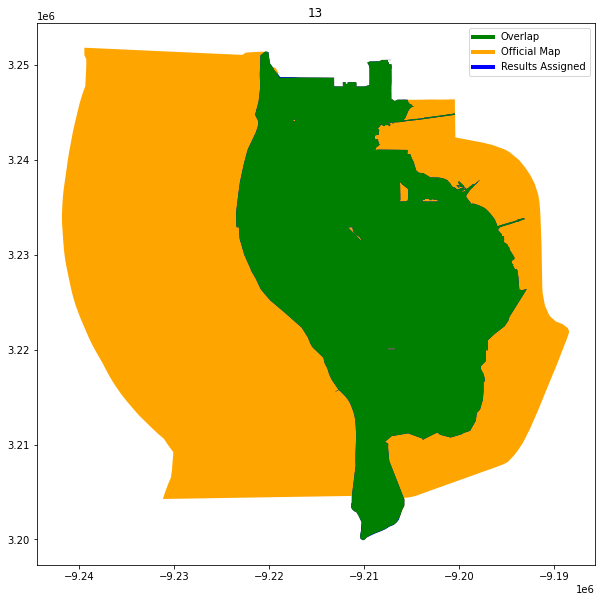

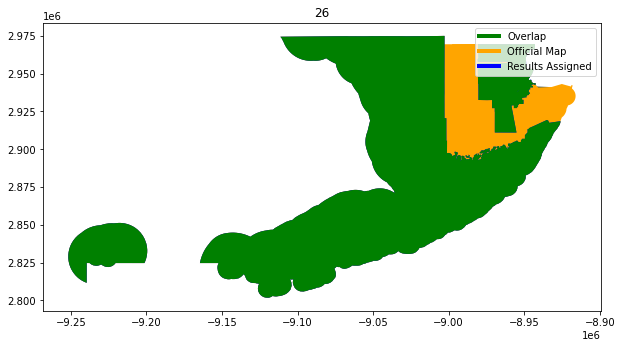

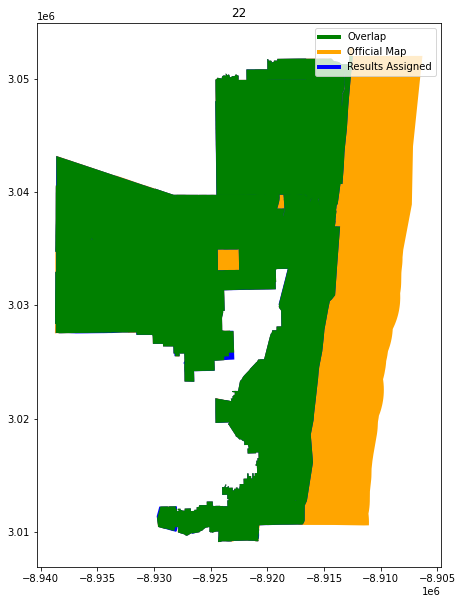

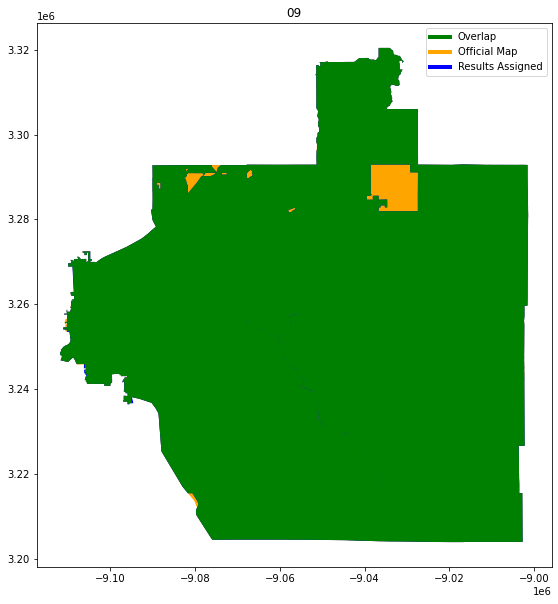

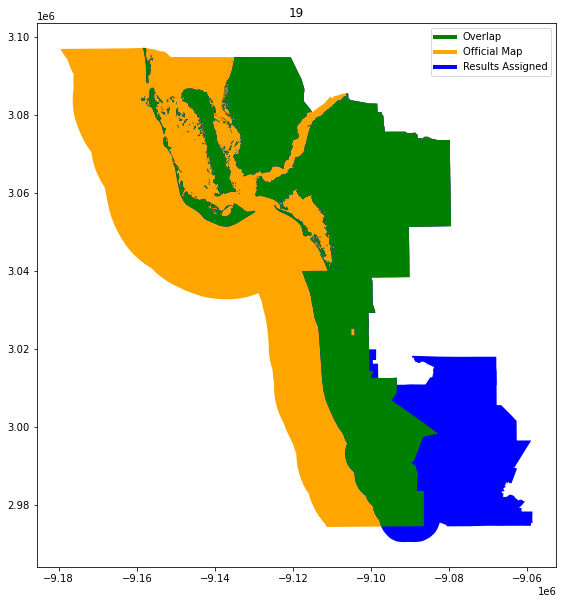

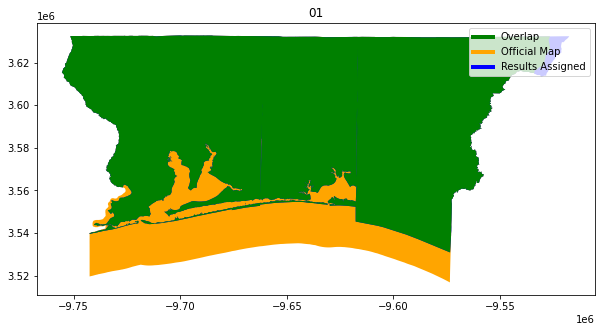

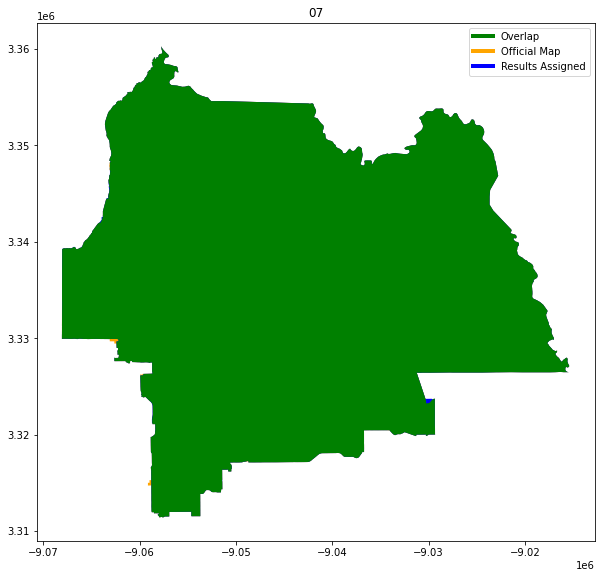

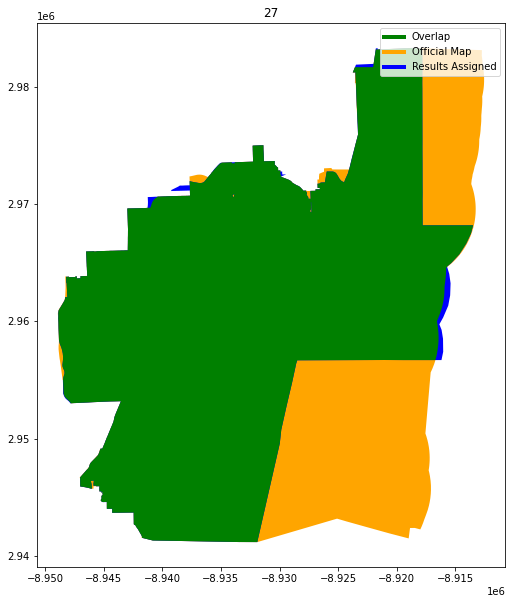

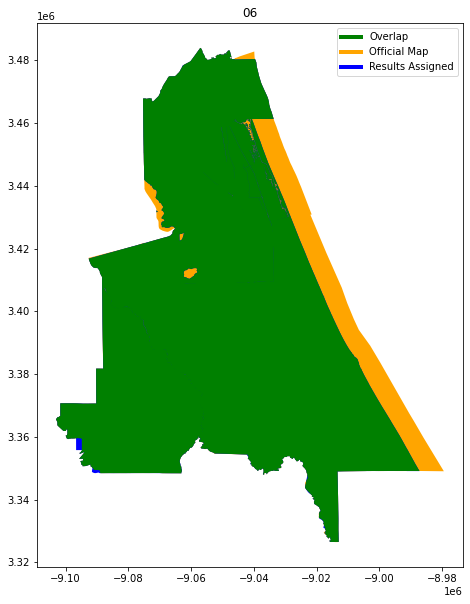

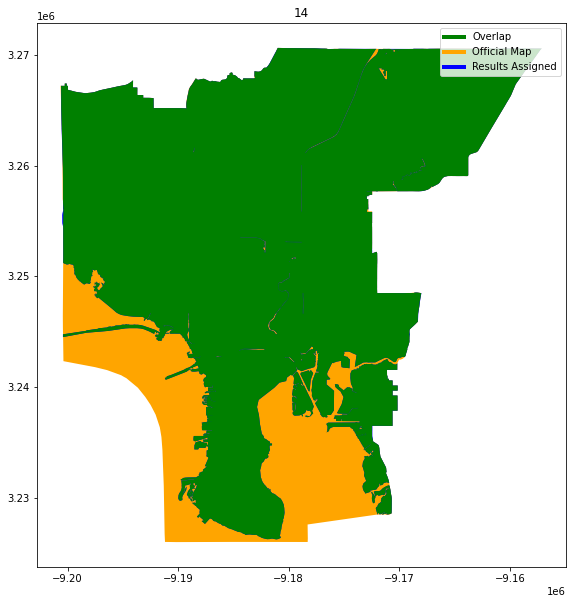

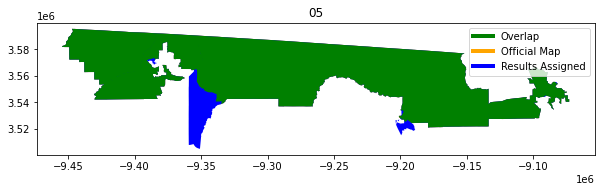

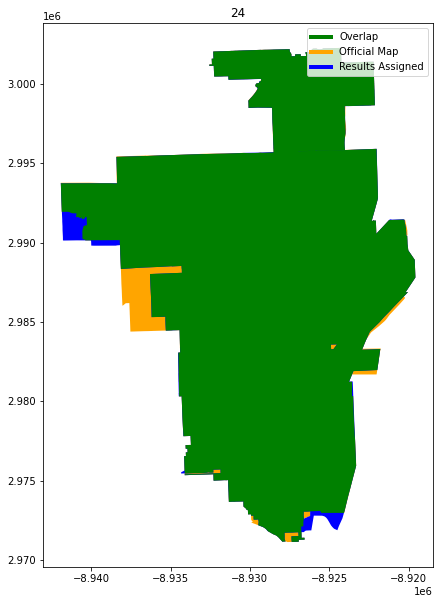

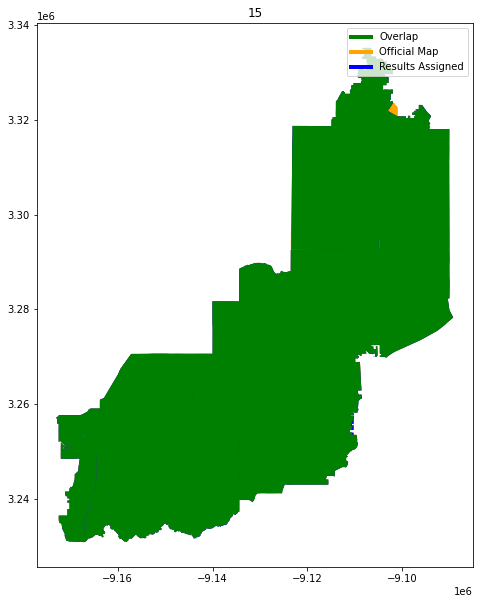

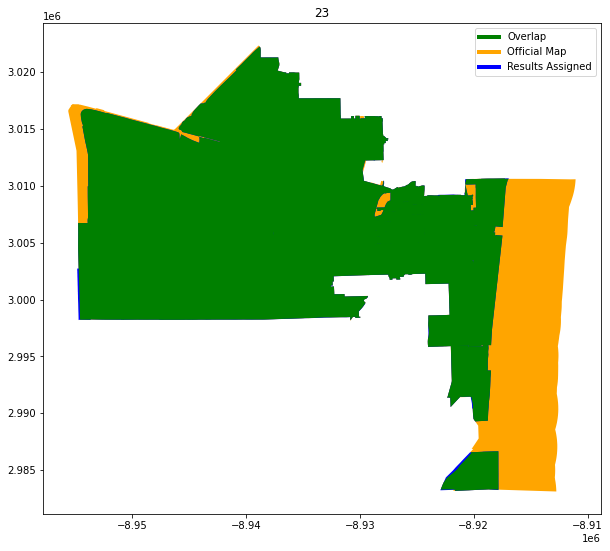

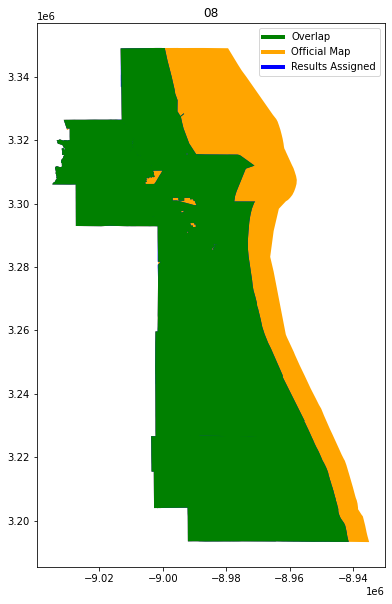

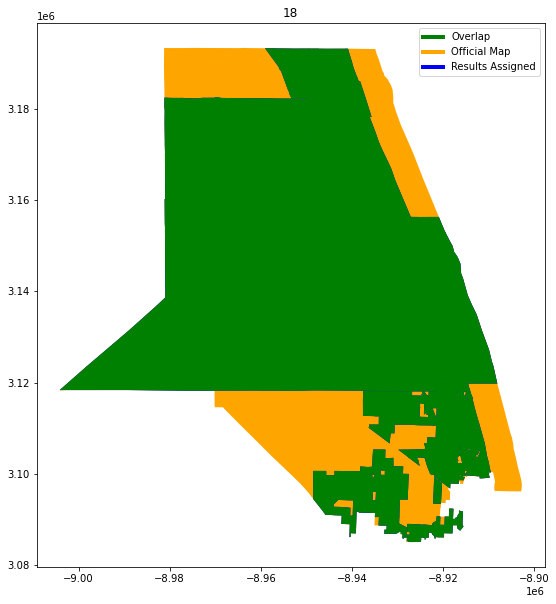

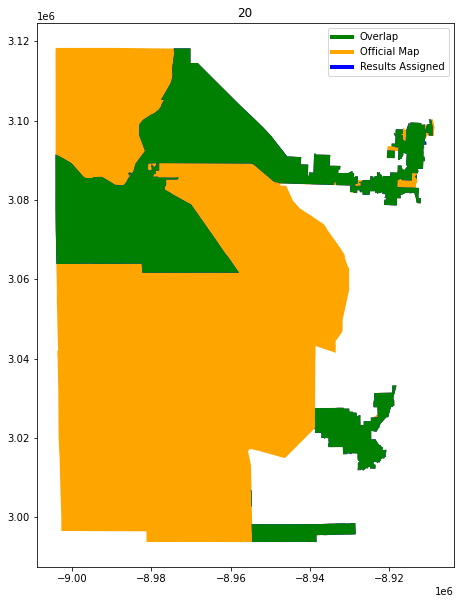

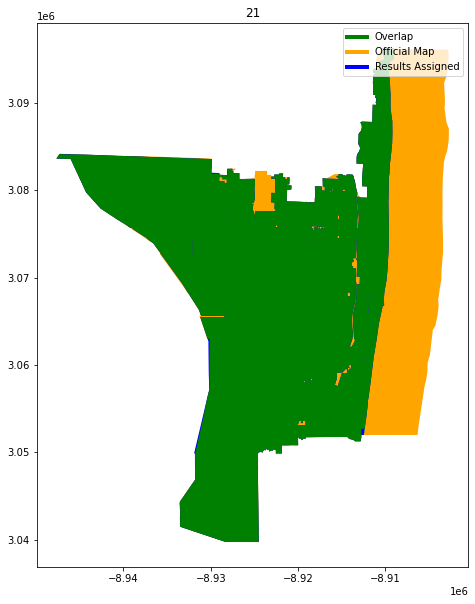

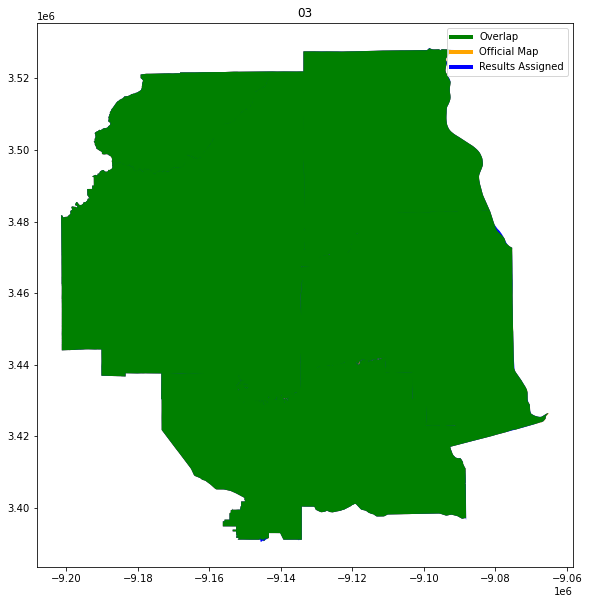

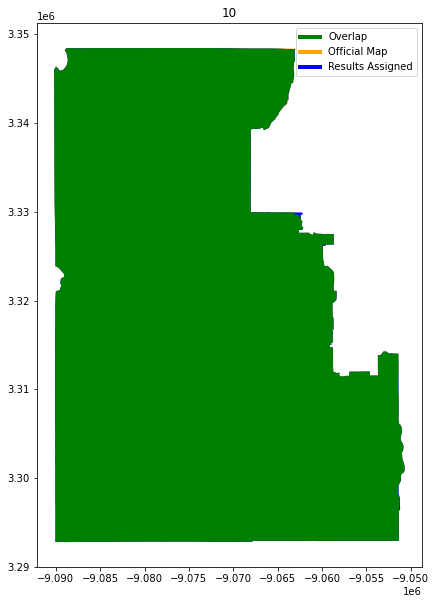

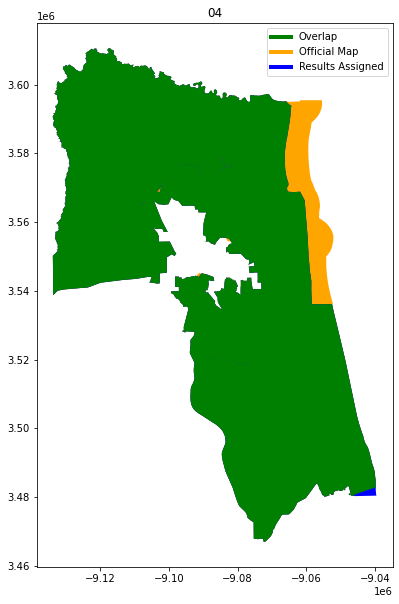

In [99]:
compare_geometries(fl_cong_shapefile,filtered_results,"Official Map","Results Assigned","CONG_DIST",area_threshold=.1)

## Add County FIPS column

In [100]:
#Load in the nationwide FIPS file
fips_file = pd.read_csv("./raw-from-source/FIPS/US_FIPS_Codes.csv")
fips_file = fips_file[fips_file["State"]=="Florida"]
fips_file["FIPS County"]=fips_file["FIPS County"].astype(str)

#Make the FIPS three digits
fips_file["FIPS County"]=fips_file["FIPS County"].str.zfill(3)
fips_file["County Name"]=fips_file["County Name"].map({'De Soto':'Desoto','St Lucie':'St. Lucie', 'St Johns':'St. Johns'}).fillna(fips_file["County Name"])

#Create the dictionary
fl_fips_dict = dict(zip(fips_file["County Name"],fips_file["FIPS County"]))


join_attempt_two["COUNTYFP"] = join_attempt_two["County Name"].map(fl_fips_dict).fillna(join_attempt_two["County Name"])

fl_fips_dict_2 = {
  'BRO':'011',
  'FLA':'035',
  'HIL':'057',
  'PIN':'103',
  'BRE':'009',
  'CLL':'021',
  'LEO':'073',
  'DAD':'086',
  'PAL':'099',
  'PAS':'101',
}

join_attempt_two["COUNTYFP"] = join_attempt_two["County Name"].map(fl_fips_dict_2).fillna(join_attempt_two["COUNTYFP"])

join_attempt_two["COUNTYFP"].unique()

array(['001', '007', '011', '019', '023', '035', '039', '057', '059',
       '065', '071', '079', '089', '091', '095', '103', '105', '107',
       '113', '117', '111', '125', '131', '003', '009', '021', '031',
       '033', '047', '061', '069', '073', '083', '085', '086', '087',
       '099', '109', '127', '097'], dtype=object)

## Election Totals Checks

In [101]:
join_attempt_two = join_attempt_two.fillna(0)
for val in state_data_columns:
    join_attempt_two[val] = join_attempt_two[val].astype(int)
    
state_data_columns.sort()

In [102]:
official_totals = pd.read_csv("./raw-from-source/Election_Results/totals/08182020Election (1).txt",sep="\t",engine='python',index_col=None)

official_totals = official_totals[official_totals["OfficeDesc"].isin(['United States Representative','State Senator', 'State Representative'])]

office_rename_dict = {'United States Representative':'PCON',
 'State Senator':'PSU',
 'State Representative':'PSL'}

official_totals["OfficeDesc"] = official_totals["OfficeDesc"].map(office_rename_dict).fillna(official_totals["OfficeDesc"])

official_totals["Juris1num"] = official_totals["Juris1num"].astype(str)
official_totals["Juris1num"] = official_totals["Juris1num"].str.zfill(3)

official_totals["Juris1num"] = np.where(official_totals["OfficeDesc"]=="PCON", official_totals["Juris1num"].str[1:], official_totals["Juris1num"])
official_totals["Juris1num"] = np.where(official_totals["OfficeDesc"]=="PSU", official_totals["Juris1num"].str[1:], official_totals["Juris1num"])

official_totals.loc[official_totals["CanNameLast"]=="Chamberlin",'CanNameLast'] = "Chmberlin"
official_totals.loc[official_totals["CanNameLast"]=="Chase",'CanNameLast'] = 'Chse'

official_totals.loc[official_totals["CanNameLast"]=="Balderramos Robinson",'CanNameLast'] = "Robinson"

official_totals.loc[official_totals["CanNameLast"]=="Hayes Hinson",'CanNameLast'] = "Hinson"
official_totals.loc[official_totals["CanNameLast"]=="Dela Rosa",'CanNameLast'] = "Rosa Dela"
official_totals.loc[official_totals["CanNameLast"]=="Vilchez Santiago",'CanNameLast'] = "Santiago Vilchez"
official_totals.loc[official_totals["CanNameLast"]=="Clark", 'CanNameLast'] = 'Drew-Montez'
official_totals.loc[official_totals["CanNameLast"]== "Louis Jeune","CanNameLast"] = "Jeune Louis"
official_totals.loc[official_totals["CanNameLast"].str.contains("Bado"), "CanNameLast"] = "Jean-Pierre"
official_totals.loc[official_totals["CanNameLast"]== "Laguerre Hylton","CanNameLast"] = "Hylton Laguerre"
official_totals.loc[official_totals["CanNameLast"]== "Rebman Lopez","CanNameLast"] = "Lopez Rebman"
official_totals.loc[official_totals["CanNameLast"]== "St. George","CanNameLast"] = "George St."
official_totals.loc[official_totals["CanNameLast"]== "Wasserman Schultz","CanNameLast"] = "Schultz Wasserman"
official_totals.loc[official_totals["CanNameLast"]=="De La Fuente","CanNameLast"] = "Fuente"


official_totals["CanNameLast_mod"] = official_totals["CanNameLast"].str[0:3].str.upper()

official_totals["cand_col_mod"] = official_totals["OfficeDesc"]+official_totals["Juris1num"]+official_totals["PartyCode"].str[0]+official_totals["CanNameLast_mod"]

official_totals_pivoted = pd.pivot_table(official_totals, index = 'CountyCode', columns = "cand_col_mod", values = "CanVotes", aggfunc = sum)

official_totals_pivoted.reset_index(inplace=True,drop=False)

official_totals_pivoted.rename(columns={"CountyCode" : "county"}, inplace = True)

official_totals_pivoted = official_totals_pivoted.fillna(0)

official_totals_pivoted.columns

us_house_cols = [i for i in official_totals_pivoted.columns if "PCON" in i]

official_totals_pivoted = official_totals_pivoted[["county"]+us_house_cols]

official_totals_pivoted["Tot_Votes"] = 0
for col in us_house_cols:
    official_totals_pivoted["Tot_Votes"] += official_totals_pivoted[col]
    
official_totals_pivoted = official_totals_pivoted[official_totals_pivoted["Tot_Votes"] > 0]


In [103]:
def county_totals_check(partner_df,source_df,column_list,county_col,full_print=False):
    """Compares the totals of two election result dataframes at the county level

    Args:
      partner_df: DataFrame of election results we are comparing against
      source_df: DataFrame of election results we are comparing to
      column_list: List of races that there are votes for
      county_col: String of the column name that contains county information
      full_print: Boolean specifying whether to print out everything, including counties w/ similarities

    Returns:
      Nothing, only prints out an analysis
    """
    
    print("***Countywide Totals Check***")
    print("")
    diff_counties=[]
    for race in column_list:
        diff = partner_df.groupby([county_col]).sum()[race]-source_df.groupby([county_col]).sum()[race]
        for val in diff[diff != 0].index.values.tolist():
            if val not in diff_counties:
                diff_counties.append(val)
        if len(diff[diff != 0]!=0):   
            print(race + " contains differences in these counties:")
            for val in diff[diff != 0].index.values.tolist():
                county_differences = diff[diff != 0]
                print("\t"+val+" has a difference of "+str(county_differences[val])+" votes")
                print("\t\tOfficial Totals: "+str(partner_df.groupby([county_col]).sum().loc[val,race])+" votes")
                print("\t\tPrecinct Results: "+str(source_df.groupby([county_col]).sum().loc[val,race])+" votes")
            if (full_print):
                for val in diff[diff == 0].index.values.tolist():
                    county_similarities = diff[diff == 0]
                    print("\t"+val + ": "+ str(partner_df.groupby([county_col]).sum().loc[val,race])+" votes")
        else:
            print(race + " is equal across all counties")
            if (full_print):
                for val in diff[diff == 0].index.values.tolist():
                    county_similarities = diff[diff == 0]
                    print("\t"+val + ": "+ str(partner_df.groupby([county_col]).sum().loc[val,race])+" votes")
    if (len(diff_counties)>0):
        print()
        print(diff_counties)

In [104]:
county_totals_check(official_totals_pivoted, join_attempt_two , state_data_columns,"county",full_print=False)

***Countywide Totals Check***

PCON01RGAE is equal across all counties
PCON01RMER is equal across all counties
PCON01RMIL is equal across all counties
PCON03DCHR is equal across all counties
PCON03DDOD is equal across all counties
PCON03DWEL is equal across all counties
PCON03RCAM is equal across all counties
PCON03RCHM is equal across all counties
PCON03RCHS is equal across all counties
PCON03RENG is equal across all counties
PCON03RGEO is equal across all counties
PCON03RMIL is equal across all counties
PCON03RROL is equal across all counties
PCON03RSAP is equal across all counties
PCON03RTHE is equal across all counties
PCON03RWEL is equal across all counties
PCON04RAGU is equal across all counties
PCON04RRUT is equal across all counties
PCON05DCHE is equal across all counties
PCON05DHOL is equal across all counties
PCON05DLAW is equal across all counties
PCON05RADL is equal across all counties
PCON05RWAG is equal across all counties
PCON06DCUR is equal across all counties
PCON06DTH

### Note: In order to make these differences match, the following votes were added /subtracted in Seminole county above

In [105]:
sem_diff

,pct_std,County Code (Three-character abbreviation),County Name,PCON21RSCA,PCON03DCHR,PCON15DHAT,PCON05DLAW,PCON15DCOH,PCON05DCHE,PCON20DHAS,PCON13RMAK,PCON03RWEL,PCON13RLUN,PCON03RENG,PCON08RPOS,PCON18RMAS,PCON19RDON,PCON23RSPA,PCON26RGIM,PCON19RASK,PCON21RACO,PCON14RQUI,PCON09RWRI,PCON19RMCL,PCON19DBAN,PCON06DCUR,PCON19RSEV,PCON19REAG,PCON19RKOW,PCON22RSWA,PCON19RAQU,PCON19DHOL,PCON03RTHE,PCON23DSCH,PCON21RFEL,PCON04RAGU,PCON22RFLY,PCON24DWIL,PCON05RADL,PCON03RROL,PCON13RBUC,PCON01RMER,PCON20RMUS,PCON21DWEI,PCON22RPRU,PCON03RGEO,PCON23DPER,PCON15DPHI,PCON22RMEL,PCON03RMIL,PCON04RRUT,PCON01RMIL,PCON09RCAS,PCON27RFIO,PCON03RSAP,PCON03RCAM,PCON05DHOL,PCON21RLOO,PCON07RVAL,PCON21DFRA,PCON27RSAL,PCON01RGAE,PCON23RKRO,PCON21RVIL,PCON18RVES,PCON26RBLA,PCON18DVAZ,PCON18DKEI,PCON14RELL,PCON03DDOD,PCON19RHEN,PCON27RMOL,PCON21RSHE,PCON24DFUE,PCON07RGOB,PCON06DTHR,PCON05RWAG,PCON15RSPA,PCON03RCHM,PCON24DLEH,PCON08RCAI,PCON15RFRA,PCON09RORT,PCON13RNEW,PCON20DCHE,PCON13RGRI,PCON03RCHS,PCON03DWEL,PCON10RFRA,PCON20RDEG,PCON19RFIG,PCON09ROLS,PCON10RMON,PCON07RZHA
0,SEMDIFF,SEM,Seminole,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [106]:
vest_fl_20.columns

Index(['pct_std', 'county', 'precinct', 'G20PRERTRU', 'G20PREDBID',
       'G20PRELJOR', 'G20PREODEL', 'G20PRESLAR', 'G20PREGHAW', 'G20PRECBLA',
       'G20PREOWRI', 'geometry'],
      dtype='object')

In [107]:
join_attempt_two = join_attempt_two[["UNIQUE_ID", "COUNTYFP",'pct_std', 'county', 'precinct','CONG_DIST']
                                    +state_data_columns+["geometry"]]

In [108]:
join_attempt_two[join_attempt_two["UNIQUE_ID"]=="STJ0208"]

,UNIQUE_ID,COUNTYFP,pct_std,county,precinct,CONG_DIST,PCON01RGAE,PCON01RMER,PCON01RMIL,PCON03DCHR,PCON03DDOD,PCON03DWEL,PCON03RCAM,PCON03RCHM,PCON03RCHS,PCON03RENG,PCON03RGEO,PCON03RMIL,PCON03RROL,PCON03RSAP,PCON03RTHE,PCON03RWEL,PCON04RAGU,PCON04RRUT,PCON05DCHE,PCON05DHOL,PCON05DLAW,PCON05RADL,PCON05RWAG,PCON06DCUR,PCON06DTHR,PCON07RGOB,PCON07RVAL,PCON07RZHA,PCON08RCAI,PCON08RPOS,PCON09RCAS,PCON09ROLS,PCON09RORT,PCON09RWRI,PCON10RFRA,PCON10RMON,PCON13RBUC,PCON13RGRI,PCON13RLUN,PCON13RMAK,PCON13RNEW,PCON14RELL,PCON14RQUI,PCON15DCOH,PCON15DHAT,PCON15DPHI,PCON15RFRA,PCON15RSPA,PCON18DKEI,PCON18DVAZ,PCON18RMAS,PCON18RVES,PCON19DBAN,PCON19DHOL,PCON19RAQU,PCON19RASK,PCON19RDON,PCON19REAG,PCON19RFIG,PCON19RHEN,PCON19RKOW,PCON19RMCL,PCON19RSEV,PCON20DCHE,PCON20DHAS,PCON20RDEG,PCON20RMUS,PCON21DFRA,PCON21DWEI,PCON21RACO,PCON21RFEL,PCON21RLOO,PCON21RSCA,PCON21RSHE,PCON21RVIL,PCON22RFLY,PCON22RMEL,PCON22RPRU,PCON22RSWA,PCON23DPER,PCON23DSCH,PCON23RKRO,PCON23RSPA,PCON24DFUE,PCON24DLEH,PCON24DWIL,PCON26RBLA,PCON26RGIM,PCON27RFIO,PCON27RMOL,PCON27RSAL,geometry


## Export File

In [109]:
if not os.path.exists('./fl_prim_20_prec/'):
    os.mkdir('./fl_prim_20_prec/')

join_attempt_two.to_file('./fl_prim_20_prec/fl_prim_20_cong_prec.shp')